# 库导入

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from joblib import Parallel, delayed
import multiprocessing
import datetime
import statsmodels.api as sm
import seaborn
from sklearn.metrics import classification_report
import talib as ta
from collections import OrderedDict #保持Key的顺序
import time
# from WindPy import *
# w.start()

from scipy import stats

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# pd.set_option('display.height',1000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

# 计算基本因子数据

**将原材料级别数据转化为因子数据并且进行初步筛选。**

## 交易日

In [3]:
TradeDateDf = pd.read_csv('D:/DWDB/%s.csv'%('AShareCalendar'))
TradeDateDf = TradeDateDf[TradeDateDf['S_INFO_EXCHMARKET'] == 'SSE']
TradeDateDf_D = TradeDateDf['TRADE_DAYS'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d')).to_frame('TRADE_DAYS').sort_values('TRADE_DAYS')

TradeDateDf_D_Used = TradeDateDf_D[(TradeDateDf_D['TRADE_DAYS']>='2005-01-01') & (TradeDateDf_D['TRADE_DAYS']<='2019-08-30')]

TradeDateDf_D_Used.index = TradeDateDf_D_Used['TRADE_DAYS']
TradeDateDf_M_Used = TradeDateDf_D_Used.resample('M').last()
TradeDateDf_M_Used.index.names = ['NOT_TRADE_DAYS']

In [2]:
##step1：获取回测区间每月最后一个交易日
# def get_trade_date(start_date, end_date, period='M'):
#     data = w.tdays(start_date, end_date, period=period) #获取每月最后一个交易日
#     trade_dates = data.Data[0]
#     trade_dates = [dt.strftime("%Y-%m-%d") for dt in trade_dates]
#     return trade_dates

# ##设置回测区间
# start_date='2019-02-01'
# end_date='2019-07-31'
# dates=get_trade_date(start_date, end_date, period='M')

In [3]:
#由于计算机构持股比例增长率（年）指标涉及到财务数据，所以需将对应的日期转化为报告期
# from dateutil.relativedelta import relativedelta
# from dateutil.parser import parse  #dateutil.parser能将任意形式的日期转化为时间类型
# def report_date(date):
#     if isinstance(date,str):    
#         date_=parse(date)
#     year=date_.year
#     month=date_.month
#     if month in [1,2,3]:  #对于1,2,3月底的财务数据采用上一年Q3数据
#         year=(date_-relativedelta(months=12)).year  #将日期前推12个月
#         report_date_=datetime(year,9,30)
#     elif month in [4,5,6,7]:
#         report_date_=datetime(year,3,31)  #对于4,5,6,7月底的财务数据用本年第一季度的数据
#     elif month in [8,9]:
#         report_date_=datetime(year,6,30)  #对于8,9月底的财务数据用本年第二季度的数据
#     elif month in [10,11,12]:
#         report_date_=datetime(year,9,30)  #对于10,11,12月底的财务数据用本年第三季度的数据
#     return report_date_.strftime('%Y-%m-%d')

In [4]:
##step2:获取回测区间每月最后一个交易日内的满足筛选条件的股票池
# def get_stocks(trDate):
#     A_stocks=w.wset("sectorconstituent","date="+trDate+";sectorid=a001010f00000000").Data[1]  #提取非ST，非PT的全部A股
#     status=w.wss(A_stocks, "trade_status,ipo_date","tradeDate="+trDate)   #提取股票的交易状态和首发上市日期
#     status=pd.DataFrame(status.Data,columns=status.Codes,index=['trade_status','ipo_date']).T
#     date_least=w.tdaysoffset(-1,trDate,'Period=Y').Data[0][0]  #获取当前时间点一年之前的日期，上市日期小于今日一年前，意味今日以上市超一年
#     trade_codes=list(status[(status['trade_status']=='交易')&(status['ipo_date']<=date_least)].index)  #选取交易且上市时间超过1年的股票,并将index转换成list格式
#     return trade_codes

## 因子数据获取 - 盈利&成长

In [ ]:
'''
成长
S_QFA_YOYSALES
S_QFA_YOYOP
S_QFA_YOYPROFIT
S_FA_YOY_EQUITY

盈利
S_QFA_ROE_DEDUCTED
S_QFA_ROA
S_QFA_GROSSPROFITMARGIN

S_QFA_ROE_DEDUCTED_YOY
S_QFA_ROA_YOY
S_QFA_GROSSPROFITMARGIN_YOY
'''

In [25]:
FinancialIndicatorDf = pd.read_csv('D:/DWDB/%s.csv'%('AShareFinancialIndicator'))

In [149]:
# 取同一公司同一天公告数据中，报告期最晚的一条数据
FinancialIndicatorDf_0 = FinancialIndicatorDf.iloc[FinancialIndicatorDf.groupby(['S_INFO_WINDCODE','ANN_DT'])['REPORT_PERIOD'].idxmax()]
# 仅保留所需因子数据
FinancialIndicator_UsedList = ['S_QFA_YOYSALES','S_QFA_YOYOP','S_QFA_YOYPROFIT','S_FA_YOY_EQUITY','S_QFA_ROE_DEDUCTED','S_QFA_ROA','S_QFA_GROSSPROFITMARGIN']
FinancialIndicatorDf_1 = FinancialIndicatorDf_0[['S_INFO_WINDCODE','ANN_DT']+FinancialIndicator_UsedList].copy()

In [14]:
# 月度非标准数据的日期转变为当月（若t>t_end，下个月）最后一个交易日
def MdateToMENDdate(FinancialIndicatorDf_1,TradeDateDf_M_Used,colname):
    '''
    第1参数，DF，包含 ANN_DT 列，公告日期，
    第2参数，DF，包含 TRADE_DAYS 列，为月度交易日，
    '''
    
    FinancialIndicatorDf_1 = FinancialIndicatorDf_1.copy()
    ## 可更改，根据ANN_DT列是否为日期
    FinancialIndicatorDf_1['TRADE_DAYS_tmp'] = FinancialIndicatorDf_1[colname].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
    #################################
    TradeDateDf_M_Used_ = TradeDateDf_M_Used.copy()
    TradeDateDf_M_Used_['TRADE_DAYS_Y_M'] = [each.strftime('%Y-%m-%d')[:7] for each in TradeDateDf_M_Used['TRADE_DAYS'].tolist()].copy()
    FinancialIndicatorDf_1['TRADE_DAYS_Y_M'] = [each.strftime('%Y-%m-%d')[:7] for each in FinancialIndicatorDf_1['TRADE_DAYS_tmp'].tolist()]
    FinancialIndicatorDf_2 = FinancialIndicatorDf_1.merge(TradeDateDf_M_Used_,on=['TRADE_DAYS_Y_M'],how='left')
    TradeDateDf_M_Used_DateList = TradeDateDf_M_Used_['TRADE_DAYS'].tolist()
    FinancialIndicatorDf_3 = FinancialIndicatorDf_2.copy()
    FinancialIndicatorDf_3['TRADE_DAYS'] = FinancialIndicatorDf_3.apply(lambda x: 
                                                                        TradeDateDf_M_Used_DateList[TradeDateDf_M_Used_DateList.index(x['TRADE_DAYS'])+1] 
                                                                        if x['TRADE_DAYS_tmp']>x['TRADE_DAYS'] 
                                                                        else x['TRADE_DAYS'] ,axis=1)
    return FinancialIndicatorDf_3
FinancialIndicatorDf_3 = MdateToMENDdate(FinancialIndicatorDf_1,TradeDateDf_M_Used,'ANN_DT')

In [151]:
# 计算同比数据（滞后4期，非标准同比）
def ComputeYoY_BUG(df,indicatorList):
    for indicator in indicatorList:
        df_ = df[['S_INFO_WINDCODE','ANN_DT',indicator]].copy().dropna()
        df_[indicator+'_YOY']=df_[indicator] - df_[indicator].shift(4)
        df = df.merge(df_[[col for col in df_.columns if col != indicator]],on=['S_INFO_WINDCODE','ANN_DT'],how='left')
    return df
indicatorList = ['S_QFA_ROE_DEDUCTED','S_QFA_ROA','S_QFA_GROSSPROFITMARGIN']
FinancialIndicatorDf_4 = FinancialIndicatorDf_3.groupby('S_INFO_WINDCODE').apply(ComputeYoY_BUG,indicatorList=(indicatorList)).copy()
FinancialIndicatorDf_4.index = FinancialIndicatorDf_4.index.droplevel(0)

In [152]:
FinancialIndicatorDf_5 = FinancialIndicatorDf_4[[col for col in FinancialIndicatorDf_4.columns if col not in ['ANN_DT','TRADE_DAYS_tmp','TRADE_DAYS_Y_M',]]].set_index(['TRADE_DAYS','S_INFO_WINDCODE']).sort_index(0).copy()
FinancialIndicatorDf_5 = FinancialIndicatorDf_5.groupby(['TRADE_DAYS','S_INFO_WINDCODE']).last().reset_index()

In [116]:
FinancialIndicatorDf_5.to_csv('D:/MultiFactorData/%s.csv'%('FinancialIndicator'))

In [76]:
FinancialIndicatorDf_5 = pd.read_csv('D:/MultiFactorData/%s.csv'%('FinancialIndicator'),parse_dates=['TRADE_DAYS'])

## 因子数据获取 - 规模&估值&流动性1

In [ ]:
'''
规模
S_VAL_MV

估值
S_VAL_PE_TTM
S_VAL_PS_TTM
S_VAL_PB_NEW

流动性1
S_DQ_FREETURNOVER

S_DQ_FREETURNOVER_20
S_DQ_FREETURNOVER_60
'''

In [494]:
DerivativeIndicatorDf = pd.read_csv('D:/DWDB/%s.csv'%('AShareEODDerivativeIndicator'))

In [160]:
# 仅保留所需因子数据
DerivativeIndicator_UsedList = ['S_VAL_MV','S_VAL_PE_TTM','S_VAL_PS_TTM','S_VAL_PB_NEW','S_DQ_FREETURNOVER',]
DerivativeIndicatorDf_0 = DerivativeIndicatorDf[['S_INFO_WINDCODE','TRADE_DT']+DerivativeIndicator_UsedList].copy()
DerivativeIndicatorDf_0['TRADE_DAYS'] = DerivativeIndicatorDf_0['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))

In [197]:
# 根据日度换手率计算月度日均换手率因子
def ComputeCrossSectionTurnOver(df):
    df = df.copy()
    S_DQ_FREETURNOVER_20 = np.mean(df['S_DQ_FREETURNOVER'].dropna().tolist()[-20:])
    S_DQ_FREETURNOVER_60 = np.mean(df['S_DQ_FREETURNOVER'].dropna().tolist()[-60:])
    return pd.DataFrame({'S_DQ_FREETURNOVER_20':[S_DQ_FREETURNOVER_20],
                          'S_DQ_FREETURNOVER_60':[S_DQ_FREETURNOVER_60],
                        })
def FreqMFactor_ComFromD(DerivativeIndicatorDf_0,TradeDateDf_M_UsedList,N):
    DerivativeIndicatorDf_1 = pd.DataFrame()
    for eachDayCnt in range(N,len(TradeDateDf_M_UsedList)):
        eachDay = TradeDateDf_M_UsedList[eachDayCnt]
        DerivativeIndicatorDf_0_sub = DerivativeIndicatorDf_0[DerivativeIndicatorDf_0['TRADE_DAYS'] <= eachDay].copy()
        DerivativeIndicatorDf_0_sub_0 = DerivativeIndicatorDf_0_sub.groupby('S_INFO_WINDCODE').apply(ComputeCrossSectionTurnOver)
        DerivativeIndicatorDf_0_sub_0.index = DerivativeIndicatorDf_0_sub_0.index.droplevel(1)
        DerivativeIndicatorDf_0_sub_0['TRADE_DAYS'] = eachDay
        DerivativeIndicatorDf_0_sub_0 = DerivativeIndicatorDf_0_sub_0.reset_index().set_index(['TRADE_DAYS','S_INFO_WINDCODE'])
        DerivativeIndicatorDf_1 = pd.concat([DerivativeIndicatorDf_1,DerivativeIndicatorDf_0_sub_0],axis=0)
    return DerivativeIndicatorDf_1

TradeDateDf_M_UsedList = TradeDateDf_M_Used['TRADE_DAYS'].tolist()
DerivativeIndicatorDf_1 = FreqMFactor_ComFromD(DerivativeIndicatorDf_0,TradeDateDf_M_UsedList,N=7)

In [220]:
DerivativeIndicatorDf_2 = DerivativeIndicatorDf_1.merge(DerivativeIndicatorDf_0,on=['TRADE_DAYS','S_INFO_WINDCODE'],how='left').set_index(['TRADE_DAYS','S_INFO_WINDCODE'])

In [221]:
DerivativeIndicatorDf_3 = DerivativeIndicatorDf_2.copy()
DerivativeIndicatorDf_3['S_VAL_MV'] = DerivativeIndicatorDf_3['S_VAL_MV'].apply(lambda x: np.log(x) if not np.isnan(x) else x)
for colname in ['S_VAL_PE_TTM','S_VAL_PS_TTM','S_VAL_PB_NEW']:
    DerivativeIndicatorDf_3[colname] = 1/DerivativeIndicatorDf_3[colname]

In [222]:
DerivativeIndicatorDf_4 = DerivativeIndicatorDf_3[[col for col in DerivativeIndicatorDf_2.columns if col not in ['TRADE_DT','S_DQ_FREETURNOVER']]]

In [254]:
DerivativeIndicatorDf_4.to_csv('D:/MultiFactorData/%s.csv'%('DerivativeIndicator'))

In [72]:
DerivativeIndicatorDf_4 = pd.read_csv('D:/MultiFactorData/%s.csv'%('DerivativeIndicator'),parse_dates=['TRADE_DAYS'])

## 因子数据获取 - 动量&波动&流动性2

In [ ]:
'''
动量
s_dq_adjclose

MOM_20
MOM_60

波动
s_dq_adjclose

VOL_20
VOL_60

流动性2
s_dq_adjclose
s_dq_amount

ILLIQ_20
'''

In [8]:
PricesDf = pd.read_csv('D:/DWDB/%s.csv'%('AShareEODPrices'))

In [9]:
# 仅保留所需因子数据
PricesDf_UsedList = ['S_DQ_ADJCLOSE','S_DQ_AMOUNT',]
PricesDf_0 = PricesDf[['S_INFO_WINDCODE','TRADE_DT']+PricesDf_UsedList].copy()
PricesDf_0['TRADE_DAYS'] = PricesDf_0['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))

### 日度数据计算月度因子 - 函数框架

In [10]:
# 根据日度价格计算月度波动 动量因子
def ComputeCrossSectionMultiFactor(df):
    df = df.copy()
    df['RET'] = df['S_DQ_ADJCLOSE']/df['S_DQ_ADJCLOSE'].shift(1)-1
    df['DELTA'] = df['S_DQ_ADJCLOSE']-df['S_DQ_ADJCLOSE'].shift(1)
    if len(df['RET'].dropna().tolist())>=60 and len(df['S_DQ_ADJCLOSE'].dropna().tolist())>=60 and len(df['S_DQ_AMOUNT'].dropna().tolist())>=60:
        VOL_20 = np.std(df['RET'].dropna().tolist()[-20:])
        VOL_60 = np.std(df['RET'].dropna().tolist()[-60:])

        MOM_20_div = df['S_DQ_ADJCLOSE'].dropna().tolist()[-1]
        MOM_20_divd = df['S_DQ_ADJCLOSE'].dropna().tolist()[-20]
        MOM_20 = MOM_20_div/MOM_20_divd-1
        MOM_60_div = df['S_DQ_ADJCLOSE'].dropna().tolist()[-1]
        MOM_60_divd = df['S_DQ_ADJCLOSE'].dropna().tolist()[-60]
        MOM_60 = MOM_60_div/MOM_60_divd-1

        ILLIQ_20_div = np.sum(np.abs(df['DELTA'].dropna().tolist()[-20:]))
        ILLIQ_20_divd = np.sum(df['S_DQ_AMOUNT'].dropna().tolist())/10**4
        ILLIQ_20 = ILLIQ_20_div/ILLIQ_20_divd
    else:
        VOL_20 = np.nan
        VOL_60 = np.nan
        MOM_20 = np.nan
        MOM_60 = np.nan
        ILLIQ_20 = np.nan
        
    S_INFO_WINDCODE = df['S_INFO_WINDCODE'].max()
    
    return pd.DataFrame({
                          'S_INFO_WINDCODE':[S_INFO_WINDCODE],
                          'VOL_20':[VOL_20],
                          'VOL_60':[VOL_60],
                          'MOM_20':[MOM_20],
                          'MOM_60':[MOM_60],
                          'ILLIQ_20':[ILLIQ_20],
                        })
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst,axis=0)
def FreqMFactor_ComFromD(PricesDf_0,TradeDateDf_M_UsedList,N):
    PricesDf_1 = pd.DataFrame()
    for eachDayCnt in range(N,len(TradeDateDf_M_UsedList)):
        eachDay = TradeDateDf_M_UsedList[eachDayCnt]
        LeachDay = TradeDateDf_M_UsedList[eachDayCnt-5]
        PricesDf_0_sub = PricesDf_0[(PricesDf_0['TRADE_DAYS'] <= eachDay) & (PricesDf_0['TRADE_DAYS'] >= LeachDay) ].copy()
        PricesDf_0_sub_0 = applyParallel(PricesDf_0_sub.groupby('S_INFO_WINDCODE'),ComputeCrossSectionMultiFactor)
        PricesDf_0_sub_0['TRADE_DAYS'] = eachDay
        PricesDf_0_sub_0 = PricesDf_0_sub_0.set_index(['TRADE_DAYS','S_INFO_WINDCODE'])
        PricesDf_1 = pd.concat([PricesDf_1,PricesDf_0_sub_0],axis=0)
        print('%.4f%% Completed'%((eachDayCnt+1)/len(TradeDateDf_M_UsedList)*100),end='\r')

    return PricesDf_1

TradeDateDf_M_UsedList = TradeDateDf_M_Used['TRADE_DAYS'].tolist()
PricesDf_1 = FreqMFactor_ComFromD(PricesDf_0,TradeDateDf_M_UsedList,N=7)

In [11]:
PricesDf_1.to_csv('D:/MultiFactorData/%s.csv'%('Prices'))

In [77]:
PricesDf_1 = pd.read_csv('D:/MultiFactorData/%s.csv'%('Prices'),parse_dates=['TRADE_DAYS'])

## 因子数据获取 - 分析师预测

In [ ]:
'''
一致预测
S_EST_PE
S_EST_ROE
S_EST_ROA
S_EST_DPS
'''

In [245]:
EarningEstDf = pd.read_csv('D:/DWDB/%s.csv'%('AShareEarningEst'))

In [246]:
# 仅保留所需因子数据
EarningEstDf_UsedList = ['S_EST_PE','S_EST_ROE','S_EST_ROA','S_EST_DPS']
EarningEstDf_0 = EarningEstDf[['S_INFO_WINDCODE','EST_DT']+EarningEstDf_UsedList].copy()

In [253]:
# 月度非标准数据的日期转变为当月（若t>t_end，下个月）最后一个交易日
def MdateToMENDdate(FinancialIndicatorDf_1,TradeDateDf_M_Used,colname):
    '''
    第1参数，DF，包含 ANN_DT 列，公告日期，
    第2参数，DF，包含 TRADE_DAYS 列，为月度交易日，
    '''
    
    FinancialIndicatorDf_1 = FinancialIndicatorDf_1.copy()
    ## 可更改，根据ANN_DT列是否为日期
    FinancialIndicatorDf_1['TRADE_DAYS_tmp'] = FinancialIndicatorDf_1[colname].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
    #################################
    TradeDateDf_M_Used_ = TradeDateDf_M_Used.copy()
    TradeDateDf_M_Used_['TRADE_DAYS_Y_M'] = [each.strftime('%Y-%m-%d')[:7] for each in TradeDateDf_M_Used['TRADE_DAYS'].tolist()].copy()
    FinancialIndicatorDf_1['TRADE_DAYS_Y_M'] = [each.strftime('%Y-%m-%d')[:7] for each in FinancialIndicatorDf_1['TRADE_DAYS_tmp'].tolist()]
    FinancialIndicatorDf_2 = FinancialIndicatorDf_1.merge(TradeDateDf_M_Used_,on=['TRADE_DAYS_Y_M'],how='left')
    TradeDateDf_M_Used_DateList = TradeDateDf_M_Used_['TRADE_DAYS'].tolist()
    FinancialIndicatorDf_3 = FinancialIndicatorDf_2.copy()
    FinancialIndicatorDf_3['TRADE_DAYS'] = FinancialIndicatorDf_3.apply(lambda x: 
                                                                        TradeDateDf_M_Used_DateList[TradeDateDf_M_Used_DateList.index(x['TRADE_DAYS'])+1] 
                                                                        if x['TRADE_DAYS_tmp']>x['TRADE_DAYS'] 
                                                                        else x['TRADE_DAYS'] ,axis=1)
    return FinancialIndicatorDf_3

In [261]:
EarningEstDf_1 = MdateToMENDdate(EarningEstDf_0,TradeDateDf_M_Used,'EST_DT')
EarningEstDf_2 = EarningEstDf_1.groupby(['S_INFO_WINDCODE','TRADE_DAYS']).mean().reset_index()
EarningEstDf_2['S_EST_PE'] = 1/EarningEstDf_2['S_EST_PE']

In [47]:
EarningEstDf_2.to_csv('D:/MultiFactorData/%s.csv'%('EarningEst'))

In [108]:
EarningEstDf_2 = pd.read_csv('D:/MultiFactorData/%s.csv'%('EarningEst'),parse_dates=['TRADE_DAYS'],index_col=0)

## 因子重命名+全表合并

In [79]:
FactorRenameDict = {
'S_QFA_YOYSALES':'SALESINCOME_YOY',
'S_QFA_YOYOP':'SALESREVENUE_YOY',
'S_QFA_YOYPROFIT':'NETPROFIT_YOY',
'S_FA_YOY_EQUITY':'EQUITY_YOY',
'S_QFA_ROE_DEDUCTED':'ROE',
'S_QFA_ROA':'ROA',
'S_QFA_GROSSPROFITMARGIN':'GROSSPM',
'S_QFA_ROE_DEDUCTED_YOY':'ROE_YOY',
'S_QFA_ROA_YOY':'ROA_YOY',
'S_QFA_GROSSPROFITMARGIN_YOY':'GROSSPM_YOY',
'S_VAL_MV':'LN_MV',
'S_VAL_PE_TTM':'EP',
'S_VAL_PS_TTM':'SP',
'S_VAL_PB_NEW':'BP',
'S_DQ_FREETURNOVER_20':'TURN_20',
'S_DQ_FREETURNOVER_60':'TURN_60',
'MOM_20':'MOM_20',
'MOM_60':'MOM_60',
'VOL_20':'VOL_20',
'VOL_60':'VOL_60',
'ILLIQ_20':'ILLIQ_20',
'S_EST_PE':'EST_EP',
'S_EST_ROE':'EST_ROE',
'S_EST_ROA':'EST_ROA',
'S_EST_DPS':'EST_DPS',
}

In [118]:
AllFactorsDf = ((DerivativeIndicatorDf_4.merge(PricesDf_1,on=['TRADE_DAYS','S_INFO_WINDCODE'],how='left')).merge(FinancialIndicatorDf_5,on=['TRADE_DAYS','S_INFO_WINDCODE'],how='left')).merge(EarningEstDf_2,on=['TRADE_DAYS','S_INFO_WINDCODE'],how='left').rename(columns=FactorRenameDict)

## 因子数据获取 - 行业因子填充

In [270]:
IndustriesClassDf = pd.read_csv('D:/DWDB/%s.csv'%('AShareIndustriesClassCITICS'))
IndustriesClassDf['ENTRY_DT'] = IndustriesClassDf['ENTRY_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
IndustriesClassDf['REMOVE_DT'] = IndustriesClassDf['REMOVE_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
IndustriesClassDf['IND_LEVEL1'] = IndustriesClassDf['CITICS_IND_CODE'].apply(lambda x: x[:4])

In [271]:
IndList = IndustriesClassDf['IND_LEVEL1'].unique().tolist()
IndDict = dict(zip(IndList,[int(i+1) for i in range(len(IndList))]))
IndustriesClassDf['Ind_CodeNum'] = IndustriesClassDf['IND_LEVEL1'].apply(lambda x: IndDict[x])

In [123]:
IndustriesClassDf_0 = IndustriesClassDf[['ENTRY_DT','S_INFO_WINDCODE','Ind_CodeNum']].rename(columns={'ENTRY_DT':'ANN_DT','Ind_CodeNum':'IND_CITICS'})

In [266]:
# 月度非标准数据的日期转变为当月（若t>t_end，下个月）最后一个交易日
def MdateToMENDdate_IND(FinancialIndicatorDf_1,TradeDateDf_M_Used,colname):
    '''
    第1参数，DF，包含 ANN_DT 列，公告日期，
    第2参数，DF，包含 TRADE_DAYS 列，为月度交易日，
    '''
    
    FinancialIndicatorDf_1 = FinancialIndicatorDf_1.copy()
    ## 可更改，根据ANN_DT列是否为日期
    FinancialIndicatorDf_1['TRADE_DAYS_tmp'] = FinancialIndicatorDf_1[colname]
    #################################
    TradeDateDf_M_Used_ = TradeDateDf_M_Used.copy()
    TradeDateDf_M_Used_['TRADE_DAYS_Y_M'] = [each.strftime('%Y-%m-%d')[:7] for each in TradeDateDf_M_Used['TRADE_DAYS'].tolist()].copy()
    FinancialIndicatorDf_1['TRADE_DAYS_Y_M'] = [each.strftime('%Y-%m-%d')[:7] for each in FinancialIndicatorDf_1['TRADE_DAYS_tmp'].tolist()]
    FinancialIndicatorDf_2 = FinancialIndicatorDf_1.merge(TradeDateDf_M_Used_,on=['TRADE_DAYS_Y_M'],how='left')
    TradeDateDf_M_Used_DateList = TradeDateDf_M_Used_['TRADE_DAYS'].tolist()
    FinancialIndicatorDf_3 = FinancialIndicatorDf_2.copy()
    FinancialIndicatorDf_3['TRADE_DAYS'] = FinancialIndicatorDf_3.apply(lambda x: 
                                                                        TradeDateDf_M_Used_DateList[TradeDateDf_M_Used_DateList.index(x['TRADE_DAYS'])+1] 
                                                                        if x['TRADE_DAYS_tmp']>x['TRADE_DAYS'] 
                                                                        else x['TRADE_DAYS'] ,axis=1)
    return FinancialIndicatorDf_3

In [267]:
IndustriesClassDf_1 = MdateToMENDdate_IND(IndustriesClassDf_0,TradeDateDf_M_Used,'ANN_DT')[['TRADE_DAYS','S_INFO_WINDCODE','IND_CITICS']]

In [278]:
## 一些显示为NaT的日期表明该公司上市时间在2005年以前，需要填充为样本时间首日以便表关联！！！
IndustriesClassDf_1['TRADE_DAYS']=IndustriesClassDf_1['TRADE_DAYS'].fillna(AllFactorsDf['TRADE_DAYS'].sort_values(ascending=True).tolist()[0])

In [280]:
AllFactorsDf_IND = AllFactorsDf.merge(IndustriesClassDf_1,on=['TRADE_DAYS','S_INFO_WINDCODE'],how='left')

In [285]:
def IND_FILL(df):
    df = df.sort_values('TRADE_DAYS').copy()
    df['IND_CITICS'] = df['IND_CITICS'].fillna(method='ffill')
    df['IND_CITICS'] = df['IND_CITICS'].fillna(method='bfill')
    return df
AllFactorsDf_INDfill = AllFactorsDf_IND.groupby('S_INFO_WINDCODE').apply(IND_FILL)
AllFactorsDf_INDfill.index = AllFactorsDf_INDfill.index.droplevel(0)

## 因子数据获取 - 财务因子&分析师预期 填充

In [288]:
FinancialFactorOld = ['S_QFA_YOYSALES',
'S_QFA_YOYOP',
'S_QFA_YOYPROFIT',
'S_FA_YOY_EQUITY',
'S_QFA_ROE_DEDUCTED',
'S_QFA_ROA',
'S_QFA_GROSSPROFITMARGIN',
'S_QFA_ROE_DEDUCTED_YOY',
'S_QFA_ROA_YOY',
'S_QFA_GROSSPROFITMARGIN_YOY',
'S_EST_PE',
'S_EST_ROE',
'S_EST_ROA',
'S_EST_DPS',]
FinancialFactorNew = [FactorRenameDict[each] for each in FinancialFactorOld]

def FinancialFactorFillna(df):
    df = df.sort_values('TRADE_DAYS').copy()
    for EachFinancialFactor in FinancialFactorNew:
#         df[EachFinancialFactor] = df[EachFinancialFactor].fillna(method='ffill',limit=2)
        df[EachFinancialFactor] = df[EachFinancialFactor].fillna(method='ffill')
    return df
AllFactorsDf_NEW = AllFactorsDf_INDfill.groupby('S_INFO_WINDCODE').apply(FinancialFactorFillna)
AllFactorsDf_NEW_NOINDEX = AllFactorsDf_NEW.copy()
AllFactorsDf_NEW_NOINDEX.index = AllFactorsDf_NEW_NOINDEX.index.droplevel(0)

# 股票池初步筛选 - 上市未满1年&ST/PT&停牌

In [289]:
IPODF = pd.read_csv('D:/DWDB/%s.csv'%'AShareIPO')
STDF = pd.read_csv('D:/DWDB/%s.csv'%'AShareST')
TradingSuspensionDF = pd.read_csv('D:/DWDB/%s.csv'%'AShareTradingSuspension')

## 上市未满1年

In [290]:
IPODF['S_IPO_LISTDATE']=IPODF['S_IPO_LISTDATE'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
IPODF_0 = IPODF[['S_INFO_WINDCODE','S_IPO_LISTDATE']]

AllFactorsDf_NEW_NOINDEX_tmp = AllFactorsDf_NEW_NOINDEX.merge(IPODF_0,on=['S_INFO_WINDCODE'],how='left')
AllFactorsDf_NEW_NOINDEX_tmp['IPOtitlNow'] = AllFactorsDf_NEW_NOINDEX_tmp['TRADE_DAYS']-AllFactorsDf_NEW_NOINDEX_tmp['S_IPO_LISTDATE']
AllFactorsDf_NEW_NOINDEX_tmp['IPOtitlNowIF'] = AllFactorsDf_NEW_NOINDEX_tmp['IPOtitlNow'].apply(lambda x: 1 if x.days>365 else 0)

AllFactorsDf_NEW_NOINDEX_tmp0 = AllFactorsDf_NEW_NOINDEX_tmp[AllFactorsDf_NEW_NOINDEX_tmp['IPOtitlNowIF']==1].copy()

## ST/PT/退市

In [293]:
STDF['ENTRY_DT'] = STDF['ENTRY_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
STDF['REMOVE_DT'] = STDF['REMOVE_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)

In [294]:
STDF_0 = STDF[['S_INFO_WINDCODE','ENTRY_DT','REMOVE_DT','S_TYPE_ST']].copy()
STDF_0['REMOVE_DT'] = STDF_0['REMOVE_DT'].fillna(datetime.datetime.strptime('2099-12-31','%Y-%m-%d'))

In [295]:
AllFactorsDf_NEW_NOINDEX_tmp1 = AllFactorsDf_NEW_NOINDEX_tmp0.merge(MdateToMENDdate_IND(STDF_0,TradeDateDf_M_Used,'ENTRY_DT'),on=['TRADE_DAYS','S_INFO_WINDCODE'],how='left')

In [296]:
def DTFillna(df):
    df = df.sort_values('S_INFO_WINDCODE').copy()
    for EachDT in ['ENTRY_DT','REMOVE_DT']:
        df[EachDT] = df[EachDT].fillna(method='ffill')
    return df
AllFactorsDf_NEW_NOINDEX_tmp2 = AllFactorsDf_NEW_NOINDEX_tmp1.groupby('S_INFO_WINDCODE').apply(DTFillna).copy()

In [297]:
STLIST = [(AllFactorsDf_NEW_NOINDEX_tmp2['TRADE_DAYS']>=AllFactorsDf_NEW_NOINDEX_tmp2['ENTRY_DT']) & (AllFactorsDf_NEW_NOINDEX_tmp2['TRADE_DAYS']<=AllFactorsDf_NEW_NOINDEX_tmp2['REMOVE_DT'])]
AllFactorsDf_NEW_NOINDEX_tmp2['ST'] = STLIST[0]
AllFactorsDf_NEW_NOINDEX_tmp3 = AllFactorsDf_NEW_NOINDEX_tmp2[AllFactorsDf_NEW_NOINDEX_tmp2['ST'] == False]
AllFactorsDf_NEW_NOINDEX_tmp3.index = AllFactorsDf_NEW_NOINDEX_tmp3.index.droplevel(0)

## 停牌

In [298]:
TradingSuspensionDF['S_DQ_RESUMPDATE'] = TradingSuspensionDF.apply(
    lambda x: x['S_DQ_RESUMPDATE'] 
    if not np.isnan(x['S_DQ_RESUMPDATE']) 
    else x['S_DQ_SUSPENDDATE'] 
    if x['S_DQ_SUSPENDTYPE'] == 444016000 or x['S_DQ_SUSPENDTYPE'] == 444007000 
    else x['S_DQ_RESUMPDATE'],axis=1)

In [299]:
TradingSuspensionDF_0 = TradingSuspensionDF[['S_INFO_WINDCODE','S_DQ_SUSPENDDATE','S_DQ_RESUMPDATE']].copy()
TradingSuspensionDF_0['S_DQ_SUSPENDDATE']=TradingSuspensionDF_0['S_DQ_SUSPENDDATE'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
TradingSuspensionDF_0['S_DQ_RESUMPDATE']=TradingSuspensionDF_0['S_DQ_RESUMPDATE'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)

In [300]:
TradingSuspensionDF_1=MdateToMENDdate_IND(TradingSuspensionDF_0,TradeDateDf_M_Used,'S_DQ_SUSPENDDATE')[['TRADE_DAYS','S_INFO_WINDCODE','S_DQ_SUSPENDDATE','S_DQ_RESUMPDATE']].copy()
TradingSuspensionDF_2 = TradingSuspensionDF_1.groupby(['TRADE_DAYS','S_INFO_WINDCODE']).last()

In [301]:
AllFactorsDf_NEW_NOINDEX_tmp4 = AllFactorsDf_NEW_NOINDEX_tmp3.merge(TradingSuspensionDF_2,on=['TRADE_DAYS','S_INFO_WINDCODE'],how='left')

In [302]:
def SUSFillna(df):
    df = df.sort_values('TRADE_DAYS').copy()
    for EachDT in ['S_DQ_SUSPENDDATE','S_DQ_RESUMPDATE']:
        df[EachDT] = df[EachDT].fillna(method='ffill',limit=4)
    return df
AllFactorsDf_NEW_NOINDEX_tmp5 = AllFactorsDf_NEW_NOINDEX_tmp4.groupby('S_INFO_WINDCODE').apply(SUSFillna).copy()
AllFactorsDf_NEW_NOINDEX_tmp5.index = AllFactorsDf_NEW_NOINDEX_tmp5.index.droplevel(0)

In [303]:
## 挑出 处于停牌区间 + 处于停牌起始但结束未知 的日期+股票
AllFactorsDf_NEW_NOINDEX_tmp5['IFSUSPEND'] \
= (AllFactorsDf_NEW_NOINDEX_tmp5['TRADE_DAYS']>=AllFactorsDf_NEW_NOINDEX_tmp5['S_DQ_SUSPENDDATE']) \
& ((AllFactorsDf_NEW_NOINDEX_tmp5['TRADE_DAYS']<=AllFactorsDf_NEW_NOINDEX_tmp5['S_DQ_RESUMPDATE'])\
   |(pd.isnull(AllFactorsDf_NEW_NOINDEX_tmp5['S_DQ_RESUMPDATE'])))
## 反选剔除
AllFactorsDf_NEW_NOINDEX_tmp6 = AllFactorsDf_NEW_NOINDEX_tmp5[AllFactorsDf_NEW_NOINDEX_tmp5['IFSUSPEND'] == False]

In [304]:
TmpCol = ['S_IPO_LISTDATE', 'IPOtitlNow', 'IPOtitlNowIF', 'ENTRY_DT', 'REMOVE_DT', 'S_TYPE_ST', 'TRADE_DAYS_tmp', 'EST_DT','TRADE_DAYS_Y_M', 'ST', 'S_DQ_SUSPENDDATE', 'S_DQ_RESUMPDATE', 'IFSUSPEND']
AllFactorsDf_V = AllFactorsDf_NEW_NOINDEX_tmp5[[col for col in AllFactorsDf_NEW_NOINDEX_tmp5.columns if col not in TmpCol]].copy()

In [305]:
AllFactorsDf_V[[col for col in AllFactorsDf_V.columns if col not in ['EST_EP']]].to_csv('D:/MultiFactorData/%s.csv'%('AllFactors'))

In [6]:
AllFactorsDf_V = pd.read_csv('D:/MultiFactorData/%s.csv'%('AllFactors'),index_col=0,parse_dates=['TRADE_DAYS'])

In [284]:
##step3:获取非财务报表性质的因子数据以及申万一级行业指数代码和A股市值等辅助指标 
# def get_factors(dates):   
#     dict_df = OrderedDict()
#     for i in range(len(dates)):    
#         date=dates[i]
#         A_stocks=get_stocks(date)  #获取当前时点满足条件的全部A股
   
#         ##提取非财务报表的数据
#         factors=w.wss(A_stocks, "industry_citic,dividendyield2,val_lnmv,pe_ttm,ps_ttm,pb_lf,estpe_FY1,estpeg_FY1,tech_turnoverrate20,tech_turnoverrate60,tech_tvma20,west_netprofit_YOY,west_sales_YOY","unit=1;tradeDate="+date+";industryType=1")
#         factors_names=['INDUSTRY','DIVIDEND_RATE','LNCAP','EP_TTM','SP_TTM','BP','FEP_TTM','CGPEG','TURN_OVER1M','TURN_OVER3M','TURN_VOL20','SALE_YOY','NET_PROFIT_YOY']                       
#         factors_=pd.DataFrame(factors.Data,index=factors_names,columns=factors.Codes).T
#         factors_['ATR1M']=w.wss(A_stocks, "ATR","tradeDate="+date+";ATR_N=20;ATR_IO=2;priceAdj=B;cycle=D").Data[0]#计算过去20个交易日内真实波幅均值
#         factors_['ATR3M']=w.wss(A_stocks, "ATR","tradeDate="+date+";ATR_N=60;ATR_IO=2;priceAdj=B;cycle=D").Data[0] #计算过去60个交易日内真实波幅均值
        
#         ##提取财务报表的数据，此处涉及报告期的折算
#         rep_date=report_date(date)
#         rep_date_bef1y=w.tdaysoffset(-1,rep_date,"Days=Alldays;Period=Y").Data[0][0].strftime('%Y-%m-%d')  #得到去年同期时间,注：此处选的是日历日
        
#         rep_factors_=w.wss(A_stocks, "qfa_yoyprofit,qfa_yoysales,qfa_yoyop,qfa_roe_deducted,qfa_roa","rptDate="+rep_date,usedf=True)[1]
#         rep_factors_names=['NET_PROFIT_YOY','OPERATE_INCOME_YOY','OPERATE_PROFIT_YOY','ROE','ROA'] 
#         rep_factors_.columns=rep_factors_names
        
#         ROE_ROA_bef1y=rep_factors=w.wss(A_stocks, "qfa_roe_deducted,qfa_roa","rptDate="+rep_date_bef1y,usedf=True)[1]  #得到去年同期的ROA和ROE
#         ROE_ROA_bef1y.columns=['ROE','ROA']   ######若想将数据框之间按列相减，列名需相同
#         rep_factors_[['DELTROE','DELTROA']]=rep_factors_[['ROE','ROA']]-ROE_ROA_bef1y   #计算DELTROE和DELTROA指标
        
#         total_factors=pd.concat([factors_,rep_factors_],axis=1) #将非财务数据与财务数据合并
        
#         #由于发现有些指标的空值是None的形式，属于Noneytpe类型，在进行运算时容易报错，所以在利用辅助指标计算因子之前，先将该缺失类型转化为float类型的缺失值
#         total_factors.iloc[:,1:]=total_factors.iloc[:,1:].astype(float)  #除去第一个行业指标外，其余指标都转化为float类型
        
#         #根据辅助指标计算因子
#         total_factors[['EP_TTM','SP_TTM','BP','FEP_TTM']]=1/total_factors[['EP_TTM','SP_TTM','BP','FEP_TTM']]  #对于EP_TTM、SP_TTM、BP、FEP_TTM指标，需对从接口取的原始数据取倒数才是对应指标的值
#         total_factors['ILLIQ']=total_factors['TURN_OVER1M'].abs()/total_factors['TURN_VOL20']  #计算非流动性冲击指标：ILLIQ=过去20个交易日的日涨跌幅绝对值/成交额均值  
#         total_factors=total_factors.drop('TURN_VOL20',axis=1)  #删除不用的辅助计算指标
        
#         dict_df[date]=total_factors  #将每期提取的指标存入字典中
#         total_factors_=pd.concat(dict_df.values(),keys=dict_df.keys())  #将提取的各指标转化为数据框
        
#     return total_factors_

# 数据预处理

In [310]:
NotNumList = ['TRADE_DAYS','S_INFO_WINDCODE','IND_CITICS']

## 异常值（Outliner）处理

$$ Median_f=median(f_i) $$
$$ MAD=median(|f_i-Median_f|) $$
$$ upper=median+3MAD $$
$$ lower=median-3MAD $$

In [311]:
#构建绝对中位数处理法函数
def extreme_process_MAD(data,num=3):#data为输入的数据集，如果数值超过num个判断标准则使其等于num个标准
    data_=data.copy()  # 为不破坏原始数据，先对其进行拷贝 
    feature_names = [i for i in data_.columns.tolist() if i not in NotNumList]   #获取数据集中需测试的因子名
    median=data_[feature_names].median(axis=0)  #获取中位数
    MAD=abs(data_[feature_names].sub(median,axis=1)).median(axis=0) #按列索引匹配，并在行中广播
    data_.loc[:,feature_names]=data_.loc[:,feature_names].clip(lower=median-num*1.4826*MAD,upper=median+num*1.4826*MAD,axis=1) #利用clip()函数，将因子取值限定在上下限范围内，即用上下限来代替异常值
    return data_

In [312]:
AllFactorsDf_V0 = AllFactorsDf_V.groupby('TRADE_DAYS').apply(extreme_process_MAD)
AllFactorsDf_V0.index = AllFactorsDf_V0.index.droplevel(0)

## 缺失值处理

填充方法1：若某一调仓日的因子值有缺失，则使用上一个调仓日的因子值进行替代，
若仍有缺失，则使用这一天股票池因子的平均值进行替代，对于行业缺失值则直接删除。

填充方法2：若某一调仓日的因子值有缺失，则使用这一天该值对应个股所属行业的因子值中位数进行替代，对于行业缺失值则直接删除。  
具体操作：将行业暂时置于index上，对多个level（时间、行业）分组，再填充。  
**填充后依然缺失则剔除，说明该因子在某个时间截面上均缺失，不能使用。**  
实现方式：分组后，组内全因子（每列）求中位数

In [313]:
def fillnull_process(df):
    NumFactorName = [col for col in df.columns if col not in NotNumList]
    MedianSeries = df[NumFactorName].median()
    return df.fillna(dict(zip(MedianSeries.index,MedianSeries.values)))

In [317]:
AllFactorsDf_V1 = AllFactorsDf_V0.groupby(['TRADE_DAYS','IND_CITICS']).apply(fillnull_process).dropna(axis=0)
AllFactorsDf_V1.index = AllFactorsDf_V1.index.droplevel([0,1])

In [318]:
#若某一调仓日的因子值有缺失，则使用上一个调仓日的因子值进行替代，若仍有缺失，则使用这一天股票池因子的平均值进行替代，对于行业缺失值则直接删除。
# def null_process(datas):
#     datas_=datas.copy()
#     ##step1:先用上一个调仓日的因子值进行缺失值填充
#     def null_process1(data):
         
#         if  True in data.isnull().any().values:#判断数据是否存在缺失值
#             data.fillna(method='ffill',limit=1,inplace=True)  #先用上一个调仓日的因子值进行缺失值填充，允许最多前向填充一个值
#         return data   
    
#     datas1=datas_.swaplevel(0,1)  #先将数据的索引互换，令股票为一级索引，时间为二级索引
#     datas1=datas1.sort_index(axis=0)
#     datas2=datas1.groupby(level=0).apply(null_process1)  #对重新索引后的数据进行缺失值处理
    
#     ##step2:若仍存在缺失值，则用该天的股票池因子的平均值代替
#     def null_process2(data):
#         if  True in data.isnull().any().values: #判断数据是否存在缺失值
#             col=[i for i in data.columns.tolist() if i not in ['INDUSTRY']] #得到因子名称
            
#             mean=data[col].mean(axis=0)  #按列求均值
#             dict_=dict(zip(mean.index.tolist(),mean.values))
#             data.fillna(dict_,inplace=True)  #用该天的股票池的平均值（OR行业中位数）来代替
#         return data
    
#     ###按照全股票中位数填充
#     datas2=datas2.swaplevel(0,1)  # 进行第一步缺失值处理后，将索引次序换回，为第二步缺失值处理做好准备
#     datas2=datas2.sort_index(axis=0)
#     datas3=datas2.groupby(level=0).apply(null_process2) #对剩余的缺失值进行填充
    
#     ###按照行业中位数填充
#     datas2=datas2.swaplevel(0,1)  # 进行第一步缺失值处理后，将索引次序换回，为第二步缺失值处理做好准备
#     datas2=datas2.reset_index().set_index(['date','INDUSTRY','codes'])
#     datas3=datas2.groupby(level=[0,2]).apply(null_process2)
    
#     ##step3:直接删除行业缺失值
#     datas4=datas3.dropna()  #对剩余的行业缺失值直接删除
#     return datas4

## 市值行业中性化处理

由于因子可能受到市值及行业的影响较大，因此需要对市值和行业进行中性化处理，即对下式做回归取残差：

$$ f_i=\beta^{MV}MV_i+\Sigma_j\beta^{ind}_jX_ij+\epsilon $$

其中$MV_i$为股票i的对数总市值，$X_{ij}$为股票i对于行业j的0-1哑变量。

In [320]:
def data_neutral(df):
    df_ = df.copy()
    X = pd.get_dummies(df_[['LN_MV','IND_CITICS']],columns=['IND_CITICS'])
    FactorNames = [col for col in df_.columns if col not in NotNumList+['LN_MV']]
    for colname in FactorNames:
        y = df_[['MOM_20']]
        residSeries = sm.OLS(y,X).fit().resid
        df_['MOM_20'] = residSeries
    return df_

In [321]:
AllFactorsDf_V2 = AllFactorsDf_V1.groupby('TRADE_DAYS').apply(data_neutral)
AllFactorsDf_V2.index = AllFactorsDf_V2.index.droplevel([0])

In [322]:
# import numpy.linalg as la   #用来做线性代数运算
# #行业市值中性化处理
# def data_scale_neutral(data):
#     data_=data.copy()
#     feature_names = [i for i in data_.columns.tolist() if i not in ['INDUSTRY','LNCAP']]   #获取数据集中需测试的因子名
#     industrys=data['INDUSTRY']  #获取所属中信一级行业代码
#     data_med = pd.get_dummies(data,columns=['INDUSTRY'],drop_first=True)
#     n = len(data['INDUSTRY'].unique())    #确定产生虚拟变量个数
#     x=pd.concat([data_[['LNCAP']],data_med[data_med.columns[-(n-1):]]])  #将虚拟变量与对数市值合并
#     X= np.array(x)  #行业虚拟变量与对数市值作为为自变量
#     for name in feature_names:
#         y = np.array(data_[name])
#         ## 矩阵写法回归
#         if la.matrix_rank(X.T.dot(X)) == (n-1): #当矩阵满秩时，估计回归参数
#             beta_ols = la.inv(X.T.dot(X)).dot(X.T).dot(y)  
#             residual = y - X.dot(beta_ols)      #计算残差，并将其作为剔除行业影响的因子值 
#         else:
#             residual = y   #如果逆不存在的话 则 用原值
#         data_[name]=residual
#         ## 线性模型回归
#         data_[name]=sm.OLS(y,X).fit().resid
#     return data_

## 标准化处理

对数据进行标准化处理，能消除量纲的影响，使数据在一个固定范围内取值。标准化处理的方法主要采用：Z 值标准化（Z-Score）。

**注：在对中性化后的数据进行标准化处理之前，要先对中心化后由残差代替的因子进行异常值处理，消除异常的残差值对分析结果的影响。**

In [323]:
AllFactorsDf_V3 = AllFactorsDf_V2.groupby('TRADE_DAYS').apply(extreme_process_MAD)
AllFactorsDf_V3.index = AllFactorsDf_V3.index.droplevel(0)

In [324]:
def scale_Zscore(df):
    df_ = df.copy()
    FactorNames = [col for col in df_.columns if col not in NotNumList]
    df_.loc[:,FactorNames] = (df_.loc[:,FactorNames].sub(df_.loc[:,FactorNames].mean(),axis=1)).div(df_.loc[:,FactorNames].std(),axis=1)
    return df_

In [325]:
AllFactorsDf_V4 = AllFactorsDf_V3.groupby('TRADE_DAYS').apply(scale_Zscore)
AllFactorsDf_V4.index = AllFactorsDf_V4.index.droplevel(0)

In [326]:
AllFactorsDf_PreT = AllFactorsDf_V4.copy()
AllFactorsDf_PreT.to_csv('D:/MultiFactorData/%s.csv'%('AllFactorsDf_PreT'),index=False)

In [327]:
# def data_scale_Z_Score(data):
#     data_=data.copy()  # 为不破坏原始数据，先对其进行拷贝 
#     feature_names = [i for i in data_.columns.tolist() if i not in ['INDUSTRY']]   #获取数据集中需测试的因子名
#     data_.loc[:,feature_names] = (data_.loc[:,feature_names] - data_.loc[:,feature_names].mean())/data_.loc[:,feature_names].std()
#     return data_

# 线性复合因子 - ICIR加权

在构建多因子选股模型时，可以通过回归法或打分法来计算因子的预期收益，由于股票收益的影响因素错综复杂，做回归时又受各种假设条件的限制，所以本文采用打分法来计算预期收益。 一般根据多个因子的线性加权来对个股进行综合打分，其形式如下所示：
$$ F=v_1*f_1+v_2*f_2+\cdots+v_k*f_k $$
其中K为因子个数$v_k$为因子权重，此处采用ICIR加权法。

In [328]:
AllFactorsDf_PreT = pd.read_csv('D:/MultiFactorData/%s.csv'%('AllFactorsDf_PreT'))  #读取之前数据预处理好的数据

In [329]:
AllFactorsDf_PreT['TRADE_DAYS'] = pd.to_datetime(AllFactorsDf_PreT['TRADE_DAYS'],format='%Y-%m-%d')

In [330]:
AllFactorList = [col for col in AllFactorsDf_PreT.columns if col not in ['TRADE_DAYS','S_INFO_WINDCODE','IND_CITICS']]

In [331]:
AllFactorsDf_PreT.head()

,TRADE_DAYS,S_INFO_WINDCODE,TURN_20,TURN_60,LN_MV,EP,SP,BP,VOL_20,VOL_60,MOM_20,MOM_60,ILLIQ_20,SALESINCOME_YOY,SALESREVENUE_YOY,NETPROFIT_YOY,EQUITY_YOY,ROE,ROA,GROSSPM,ROE_YOY,ROA_YOY,GROSSPM_YOY,EST_ROE,EST_ROA,EST_DPS,IND_CITICS
0,2006-04-28,000028.SZ,-0.229854,-0.733107,0.016303,-0.023065,1.349020,-1.032907,-0.081909,-0.586607,0.164840,-0.099084,0.668220,0.435974,1.255465,-0.104295,0.804037,0.440388,0.176480,-0.115603,-0.095994,-0.048630,0.739330,0.384017,0.163142,0.473694,1.0
1,2006-04-28,000078.SZ,-1.185069,-0.491525,-0.127017,-0.192027,1.903838,-0.032490,-0.128873,-0.369300,2.182332,1.785330,-0.309656,-1.408638,-2.029013,-1.992455,-1.967729,-2.036267,-2.088112,-2.093084,-2.050326,-2.100863,-1.329217,-0.000227,0.163142,0.473694,1.0
2,2006-04-28,000153.SZ,1.342204,1.326111,-0.837297,-1.022088,-0.240500,1.266462,-0.475452,-0.855543,-0.394147,-0.456334,-0.133007,0.913109,-0.699454,0.689318,-0.199549,-0.315715,-0.336951,-0.077487,-0.166506,0.010345,-0.432804,-0.000227,0.163142,0.473694,1.0
3,2006-04-28,000403.SZ,-0.374821,-0.228946,-1.268230,-0.192027,0.884505,2.343782,1.445861,2.101721,0.638049,-2.199667,0.108535,0.910712,0.630782,0.304160,-1.967729,-0.459883,-0.448982,0.150747,-0.258722,-0.108034,-0.312534,-0.000227,0.163142,0.473694,1.0
4,2006-04-28,000411.SZ,0.134907,-0.069723,-1.146207,-1.114434,2.280506,-1.485034,0.755034,0.428482,0.319426,-0.861544,0.051200,0.476464,0.173087,-0.242754,0.527779,-0.178846,-0.221051,-1.091366,-0.258722,-0.015904,0.030101,-0.000227,0.163142,0.473694,1.0


## 因子多重共线性处理

由于通过线性加权来对个股进行综合打分的一个重要隐含假设是因子之间的相关系数较低。若因子之间的相关性较高，就会使组合对于某些风格过分暴露，进而影响组合长期表现的稳定性。

### 因子间相关性强弱示意图 - 某一截面

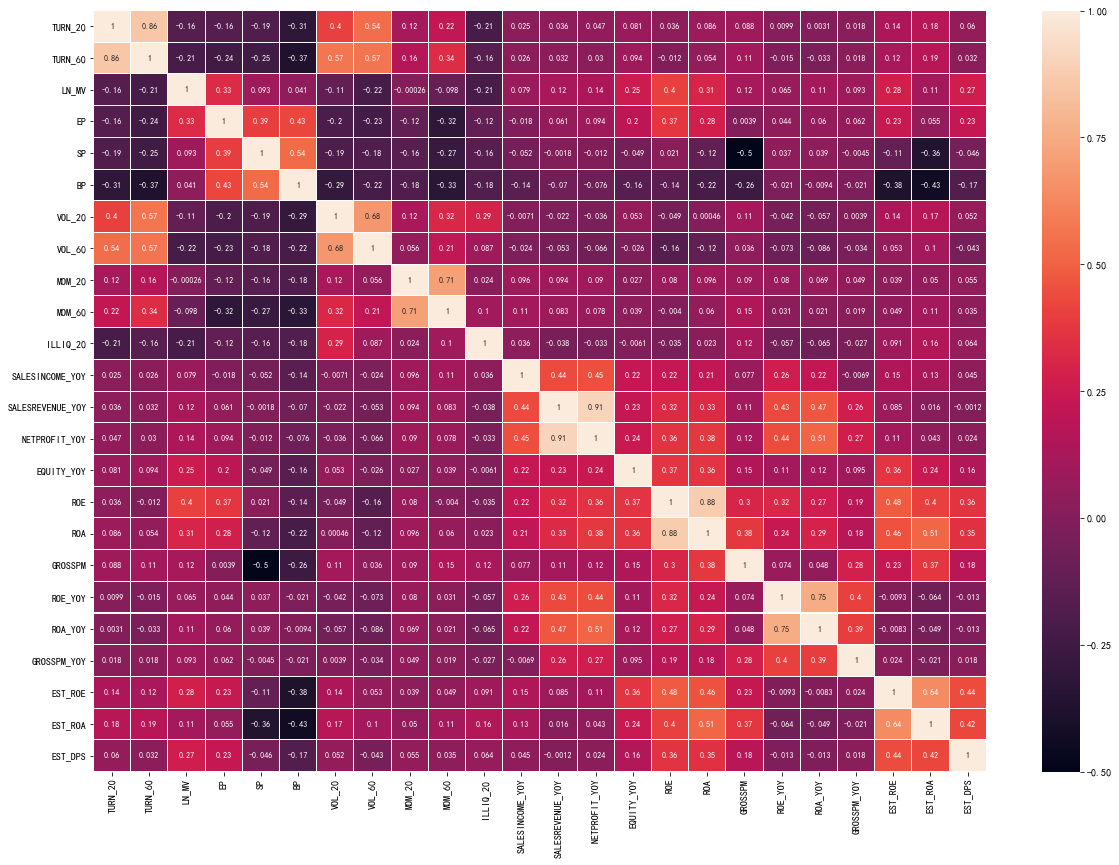

In [332]:
#绘制因子相关性的热力图
fig=plt.figure(figsize=(20,14))
data=AllFactorsDf_PreT[AllFactorsDf_PreT['TRADE_DAYS']=='2018-06-29']
relations= data.iloc[:,:-1].corr()
seaborn.heatmap(relations,annot=True,linewidths=0.05,linecolor='white',annot_kws={'size':8,'weight':'bold'})

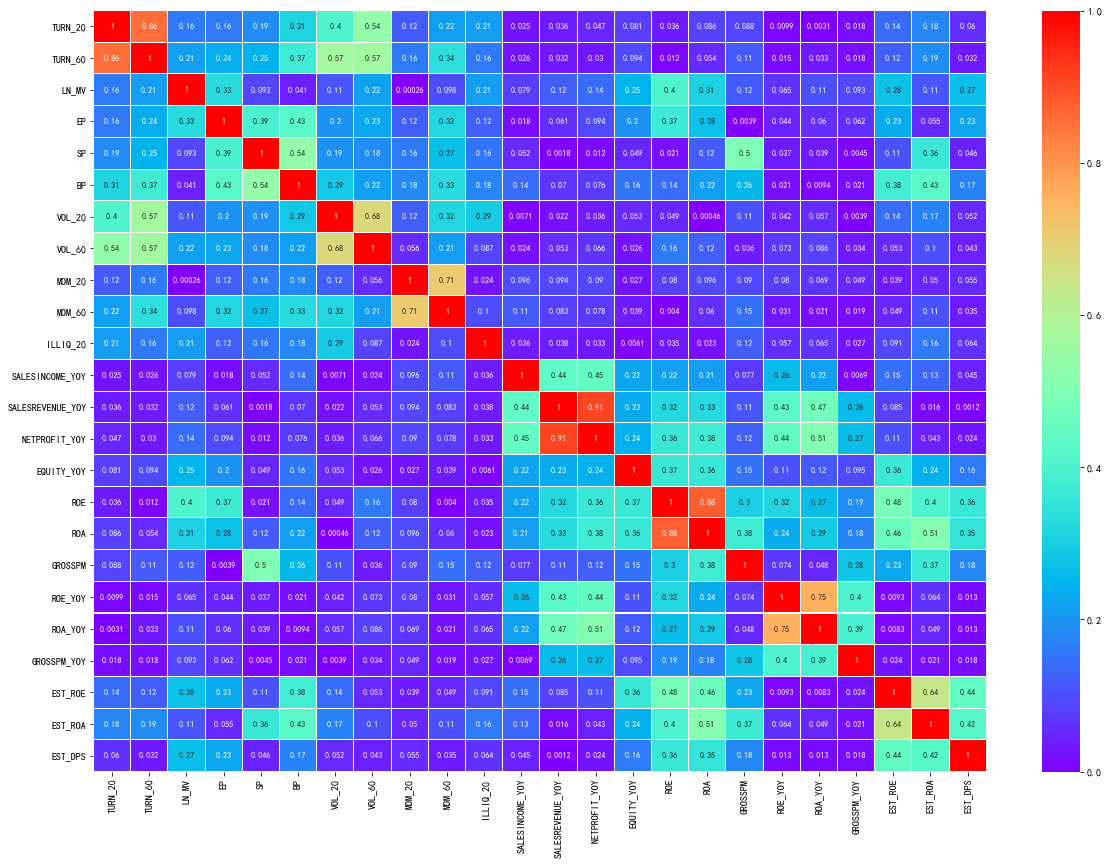

In [333]:
plt.figure(figsize=(20,14))
seaborn.heatmap(abs(relations),annot=True,linewidths=0.05,linecolor='white',annot_kws={'size':8,'weight':'bold'},cmap='rainbow')

### 因子间相关性强弱示意图 - 所有截面平均

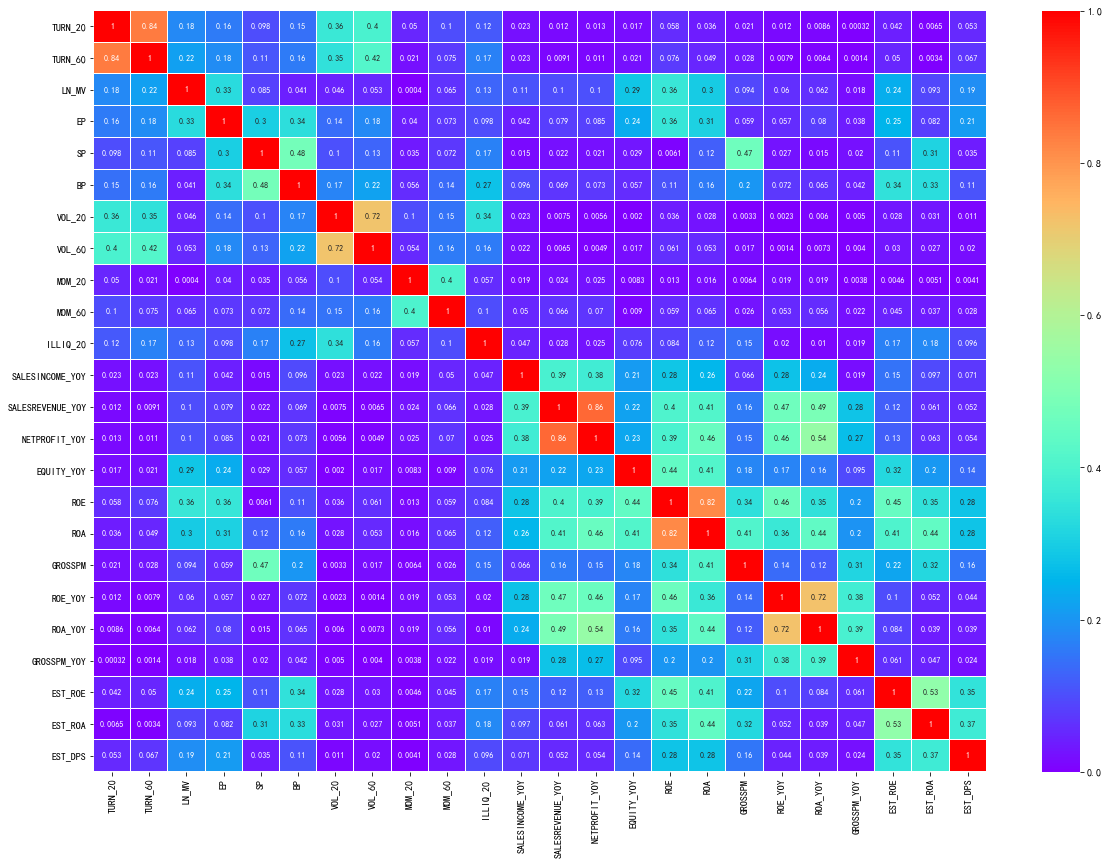

In [334]:
TradeDateList = AllFactorsDf_PreT['TRADE_DAYS'].unique()
Tolcorrmat={}
for TradeDate in TradeDateList:
    data=AllFactorsDf_PreT[AllFactorsDf_PreT['TRADE_DAYS']==TradeDate]
    corrmat=data.iloc[:,:-1].corr()
    Tolcorrmat[TradeDate]=corrmat
TolcorrmatValue = sum([Tolcorrmat[key] for key in Tolcorrmat.keys()])/len(Tolcorrmat.keys())
plt.figure(figsize=(20,14))
seaborn.heatmap(abs(TolcorrmatValue),annot=True,linewidths=0.05,linecolor='white',annot_kws={'size':8,'weight':'bold'},cmap='rainbow')

### 多重共线性处理：对称正交法

定义一个从$F_{N*K}$旋转到$\overset{\sim}F_{N*K}$的过渡矩阵$S_{K*K}$，公式如下所示：
$$ S_{K*K}=U_{K*K}D_{K*K}^{-1/2}U_{K*K}^T $$
其中，记矩阵$M=F_{N*K}^TF_{N*K}$,$D_{K*K}$为M的特征根构成的对角阵，$U_{K*K}$为每一列由M的特征向量构成的矩阵。$S_{K*K}$是一个对角矩阵，所以我们才称之为对称正交,$F_{N*K}$的旋转公式如下：
$$\overset{\sim}F_{N*K}=F_{N*K}S_{K*K}$$

In [335]:
def lowdin_orthogonal(data):
    data_=data.copy()
    col=[i for i in data_.columns.tolist() if i not in NotNumList]
    F=np.array(data_[col])  ##除去第一列行业指标,将数据框转化为矩阵
    M=np.dot(F.T,F)
    a,U= np.linalg.eig(M)  #U为特征向量，a为特征值
    one=np.identity(len(col))
    D=one*a  #生成有特征值组成的对角矩阵
    D_inv=np.linalg.inv(D)
    S=U.dot(np.sqrt(D_inv)).dot(U.T)
    data_[col]=data_[col].dot(S)
    return data_

In [336]:
AllFactorsDf_PreTAfrOr = AllFactorsDf_PreT.groupby('TRADE_DAYS').apply(lowdin_orthogonal).copy()
AllFactorsDf_PreTAfrOr.index = AllFactorsDf_PreTAfrOr.index.droplevel(0)

### 因子间相关性强弱示意图 - 正交后

正交后的平均因子截面相关性大幅度接近0

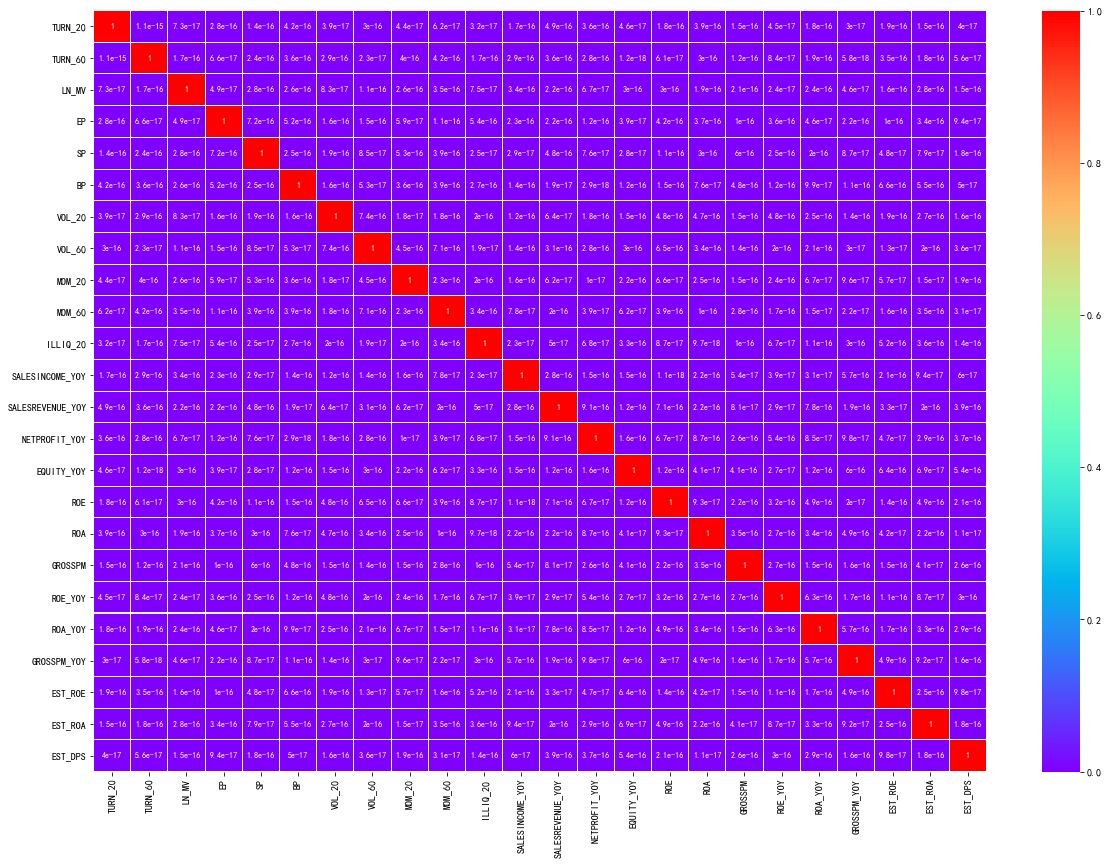

In [337]:
TradeDateList = AllFactorsDf_PreTAfrOr['TRADE_DAYS'].unique()
Tolcorrmat={}
for TradeDate in TradeDateList:
    data=AllFactorsDf_PreTAfrOr[AllFactorsDf_PreTAfrOr['TRADE_DAYS']==TradeDate]
    corrmat=data.iloc[:,:-1].corr()
    Tolcorrmat[TradeDate]=corrmat
TolcorrmatValue = sum([Tolcorrmat[key] for key in Tolcorrmat.keys()])/len(Tolcorrmat.keys())
plt.figure(figsize=(20,14))
seaborn.heatmap(abs(TolcorrmatValue),annot=True,linewidths=0.05,linecolor='white',annot_kws={'size':8,'weight':'bold'},cmap='rainbow')

## 打分法计算预期收益/因子得分/复合因子

### 计算下月收益因子

In [338]:
PricesDf = pd.read_csv('D:/DWDB/%s.csv'%('AShareEODPrices'))
PricesDf['TRADE_DAYS'] = PricesDf['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))

In [339]:
PricesDf_tmp0 = PricesDf[['TRADE_DAYS','S_INFO_WINDCODE','S_DQ_ADJCLOSE']]

In [340]:
def DtoM(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    df_0=df_.set_index('TRADE_DAYS')
    df_0['TRADE_DAYS']=df_0.index
    df_1=df_0.apply(lambda x: x.resample('M').last())
    return df_1
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst,axis=0)
PricesDf_tmp1=applyParallel(PricesDf_tmp0.groupby('S_INFO_WINDCODE'),DtoM)

In [341]:
PricesDf_tmp1.index = np.arange(len(PricesDf_tmp1))

In [342]:
def ComputeRet(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    df_['NEXT_RET']=(df_['S_DQ_ADJCLOSE']/df_['S_DQ_ADJCLOSE'].shift(1)-1).shift(-1)
    return df_
PricesDf_tmp2=applyParallel(PricesDf_tmp1.groupby('S_INFO_WINDCODE'),ComputeRet)
PricesDf_tmp2.index = np.arange(len(PricesDf_tmp2))

In [343]:
AllFactorsDf_PreTAfrOr_Ret = AllFactorsDf_PreTAfrOr.merge(PricesDf_tmp2[['TRADE_DAYS','S_INFO_WINDCODE','NEXT_RET']],on=['TRADE_DAYS','S_INFO_WINDCODE'],how='left')

### 简单回测因子收益

In [344]:
AllFactorsDf_PreTAfrOr_Ret.columns

Index(['TRADE_DAYS', 'S_INFO_WINDCODE', 'TURN_20', 'TURN_60', 'LN_MV', 'EP', 'SP', 'BP', 'VOL_20', 'VOL_60', 'MOM_20', 'MOM_60', 'ILLIQ_20', 'SALESINCOME_YOY', 'SALESREVENUE_YOY', 'NETPROFIT_YOY', 'EQUITY_YOY', 'ROE', 'ROA', 'GROSSPM', 'ROE_YOY', 'ROA_YOY', 'GROSSPM_YOY', 'EST_ROE', 'EST_ROA', 'EST_DPS', 'IND_CITICS', 'NEXT_RET'], dtype='object')

In [358]:
def FactorReturn(df):
    df_=df.copy()
    N = int(len(df_)/5)
    F='VOL_20'
    ret=df_.sort_values(F,ascending=False).head(N).mean()['NEXT_RET']
    ret1=df_.sort_values(F,ascending=False).tail(N).mean()['NEXT_RET']
    ret2=ret-ret1
    return pd.DataFrame([ret,ret1,ret2]).T
TT = AllFactorsDf_PreTAfrOr_Ret.groupby('TRADE_DAYS').apply(FactorReturn)
TT.mean()/TT.std()*12**0.5

0    0.582532
1    0.755071
2   -0.303659
dtype: float64

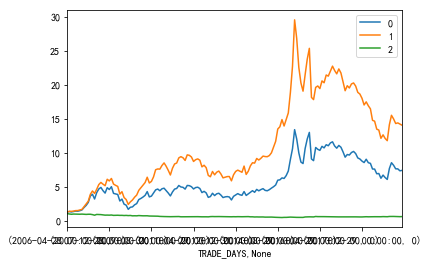

In [359]:
(TT+1).cumprod().plot()

### 计算ICIR权重
在利用IR加权法计算权重时，各因子权重值为各因子在滚动时间内平均IR值在所有因子在滚动时间内平均IR值之和中的占比，因子在滚动时间内平均IR值越大，说明该因子在选股时作用越大，权重也越大，反之亦然。在利用IR计算权重时需注意的是：在滚动计算IC序列标准差时，起始日期得到的是缺失值，所以对于起始日期的IR值我们用该时点的IC值来代替， 得到的权重也为IC值计算的IC权重。

**计算未来一期收益后计作next_ret因子置入因子暴露表，截面回归得到IC序列，往后滞后一期限**

In [360]:
def computeFutureIC(df):
    df_=df.dropna(axis=0)
    factor_name = [col for col in df_.columns if col not in NotNumList+['NEXT_RET']]
    spearmanR = [[stats.spearmanr(df_[factor],df_['NEXT_RET'])[0]] for factor in factor_name]
    return pd.DataFrame(dict(zip(factor_name,spearmanR)))
FactorFutureIC = AllFactorsDf_PreTAfrOr_Ret.groupby('TRADE_DAYS').apply(computeFutureIC).copy()
FactorFutureIC.index = FactorFutureIC.index.droplevel(1)
FactorFutureIC = FactorFutureIC.reset_index()

In [361]:
def computeFutureIR(df):
    df_0=df[['TRADE_DAYS']].copy()
    df_=df[[col for col in df.columns if col not in ['TRADE_DAYS']]].copy()
    rollmean=df_.rolling(12,min_periods=1).mean()
    rollstd=df_.rolling(12,min_periods=2).std()
    IRdf=rollmean/rollstd
    IRdf.iloc[0,:]=df_.iloc[0,:]
    return pd.concat([df_0,IRdf],axis=1)

In [362]:
FactorFutureIR=computeFutureIR(FactorFutureIC)

In [363]:
FactorIC=FactorFutureIC.copy()
FactorIR=FactorFutureIR.copy()
FactorIC.iloc[:,1:]==FactorIC.iloc[:,1:].shift(1)
FactorIR.iloc[:,1:]=FactorIR.iloc[:,1:].shift(1)

### 因子平均IC/IR值展示

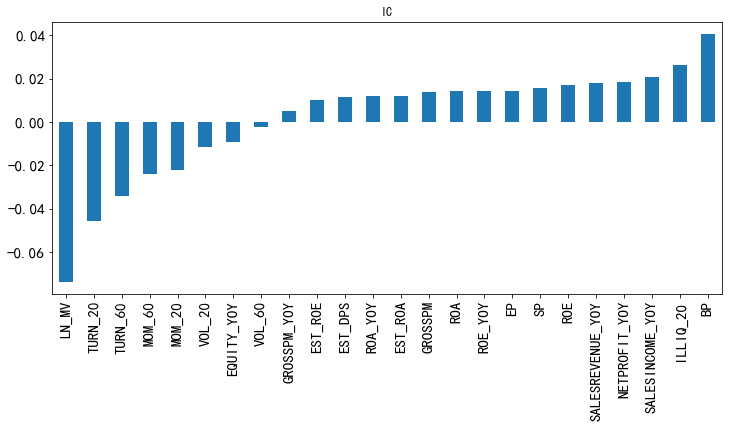

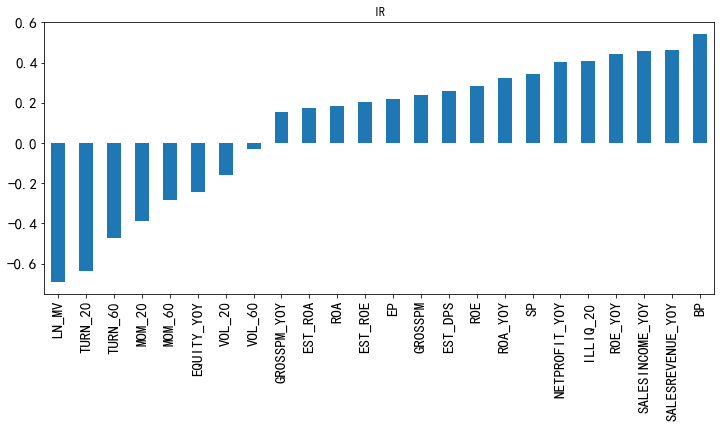

In [364]:
FactorIC.set_index('TRADE_DAYS').mean().sort_values().plot.bar(figsize=(12,5),fontsize=15,title='IC')
plt.show()
FactorIR.set_index('TRADE_DAYS').mean().sort_values().plot.bar(figsize=(12,5),fontsize=15,title='IR')
plt.show()

In [ ]:
#根据IR计算因子权重

# ##step1:计算IC值
# def get_ic(datas):
#     factors_name=[i for i in datas.columns.tolist() if i not in ['next_ret','INDUSTRY']]  #得到因子名
#     ic = datas.groupby(level=0).apply(lambda data: [stats.spearmanr(data[factor],data['next_ret'])[1] for factor in factors_name])  #得到的是以列表为值的序列
#     ic = pd.DataFrame(ic.tolist(), index=ic.index, columns=factors_name)  #得到各因子IC值,一个list为一个列
#     return ic

# ##step2: 计算IR权重
# def IR_weight(datas):
#     datas_=datas.copy()
#     ic=get_ic(datas)  #计算ic值，得到ic的
#     ic0 = ic.abs() #计算ic的绝对值
#     rolling_ic = ic0.rolling(12,min_periods=1).mean()  #rolling为移动窗口函数,滚动12个月
#     rolling_ic_std=ic0.rolling(12,min_periods=1).std()  #当滚动计算标准差时，起始日期得到的是缺失值，所以算完权重后，起始日期的值任用原值IC代替 
#     IR=rolling_ic/rolling_ic_std  #计算IR值
#     IR.iloc[0,:]=rolling_ic.iloc[0,:]
#     weight = IR.div(IR.sum(axis=1),axis=0)  #计算IR权重,按行求和,按列相除
#     return weight

In [ ]:
# IR_weight=IR_weight(datas)

### 计算因子得分

In [365]:
def ComputeScore(df,Weight=FactorIR):
    df_=df[[col for col in df.columns if col not in ['S_INFO_WINDCODE','IND_CITICS']]].copy()
    DAYSDF = df_[['TRADE_DAYS']]
    FactorIR_sub = DAYSDF.merge(FactorIR,on=['TRADE_DAYS'],how='left')
    FactorMultiW = FactorIR_sub.set_index(['TRADE_DAYS'])*df_.set_index(['TRADE_DAYS'])
    Score = FactorMultiW.sum(axis=1).to_frame('SCORE')
    FactorMultiW_ = pd.concat([df.reset_index(drop=True).set_index('TRADE_DAYS'),Score],axis=1)
    return FactorMultiW_

In [366]:
AllFactorsDf_PreTAfrOrScore = AllFactorsDf_PreTAfrOr.groupby('S_INFO_WINDCODE').apply(ComputeScore,Weight=FactorIR)
AllFactorsDf_PreTAfrOrScore.index = AllFactorsDf_PreTAfrOrScore.index.droplevel(0)
AllFactorsDf_PreTAfrOrScore = AllFactorsDf_PreTAfrOrScore.reset_index()

In [367]:
AllFactorsDf_PreTAfrOrScore.to_csv('D:/MultiFactorData/%s.csv'%('AllFactorsDf_PreTAfrOrScore'))

In [5]:
AllFactorsDf_PreTAfrOrScore = pd.read_csv('D:/MultiFactorData/%s.csv'%('AllFactorsDf_PreTAfrOrScore'),index_col=0,parse_dates=['TRADE_DAYS'])

In [ ]:
#根据IR权重计算因子得分
# def get_score(weight,datas):
#     col=[i for i in datas.columns.tolist() if i not in ['next_ret','INDUSTRY']]  #得到因子名
#     datas_=datas[col]
#     score_=OrderedDict()
#     for date in weight.index.tolist():
#         data=datas_.loc[date]  #提取各时间点的因子值
#         score=data*(weight.loc[date])  #利用因子值和IR权重计算各时间点的因子综合得分
#         score_[date]=score.sum(axis=1).to_frame().rename(columns={0: 'score'})
#     score_df=pd.concat(score_.values(),keys=score_.keys())
#     score_df.index.names=['date','codes']
#     datas=datas.join(score_df)
#     return datas

# 首尾分组法 - 多因子策略

In [22]:
# 基本数据
## 月末交易日数据
TradeDateDf_M_Used = TradeDateDf_M_Used.copy()
## 收盘价行情数据
PricesDf = pd.read_csv('D:/DWDB/%s.csv'%('AShareEODPrices'))
PricesDf['TRADE_DAYS'] = PricesDf['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
PricesDfForBackTest = PricesDf[['TRADE_DAYS','S_INFO_WINDCODE','S_DQ_ADJCLOSE']].copy()

## 净值分析函数

In [25]:
### 分析函数 - 计算各类指标
def Indicator(equity_df,strategy_name):
    '''
    输入净值序列，一列净值，index为日期
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    col_name = df.columns[0]
    trade_len = (equity_df.index[-1] - equity_df.index[0]).days
    df['return'] = df[col_name]/df[col_name].shift(1)-1
    df['drawdown'] = 1-df[col_name]/df[col_name].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df[col_name][-1]/df[col_name][0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = (cum_return+1)**(365.25/trade_len)-1
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 信息比率
    IR = mean_return/vol_return
    # 年化收益回撤比
    mean_return_max_drawdown_ratio = mean_return/max_drawdown
    # 夏普比率
    sharpe_ratio = (mean_return-0.03)/vol_return
    # 每年收益率
    df_equity = df[[col_name]].copy()
    df_return_per_year = (pd.concat([df_equity.iloc[:1,:],df_equity.apply(lambda x: x.resample("Y").last())],axis=0).pct_change().dropna()).rename(columns={col_name:strategy_name})
    # 最大回撤结束、开始时间，持续时长
    max_drawdown_end = df['drawdown'].idxmax()
    max_drawdown_end_str = max_drawdown_end.strftime('%Y-%m-%d')
    df_before_max_drawdowm = df[df.index<=max_drawdown_end].copy()
    max_drawdown_start = df_before_max_drawdowm[df_before_max_drawdowm['drawdown'] == 0].index[-1]
    max_drawdown_start_str = max_drawdown_start.strftime('%Y-%m-%d')
    max_drawdown_year = (max_drawdown_end - max_drawdown_start).days/365.25

    output_dict = {
                   'mean_return':[mean_return],
                   'vol_return':[vol_return],
                   'IR':[IR],
                   'sharpe_ratio':[sharpe_ratio],
                   'max_drawdown':[max_drawdown],
                   'mean_return_max_drawdown_ratio':[mean_return_max_drawdown_ratio],
                   'max_drawdown_start':[max_drawdown_start_str],
                   'max_drawdown_end':[max_drawdown_end_str],
                   'max_drawdown_last_Y':[max_drawdown_year],
                  }
    output_df = pd.DataFrame(output_dict,index=[strategy_name]).T
    return output_df, df, df_return_per_year

## 策略内容
不属于指数增强策略，因为不需要与基准指数有交互。  
是可以适用于任意单因子的回测框架（复合因子也可视作单因子）。

In [370]:
# FactorForBackTest = 'SCORE'
BINS = 5
FactorForBackTest_DF = AllFactorsDf_PreTAfrOrScore.copy()

In [371]:
def FactorCutBins(df,FactorForBackTest):
    df_ = df.copy()
    Labels = ['G'+str(num) for num in range(1,BINS+1)]
    LabelsDf = pd.qcut(df_[FactorForBackTest].sort_values(ascending=True),q = BINS, labels = False, duplicates='drop')
    df_['GROUP_'+FactorForBackTest] = LabelsDf
    return df_
def ComputeWeight(df,FactorForBackTest,how='H'):
    df_ = df.copy()
    if how == 'H':
        ChosenStock = BINS-1
    elif how == 'L':
        ChosenStock = 0
    weight_name_each = 'Weight_%s_%s'%(FactorForBackTest,how)
    df_[weight_name_each]=df_['GROUP_'+FactorForBackTest].apply(lambda x: 1 if x==ChosenStock else 0)
    df_[weight_name_each]=df_[weight_name_each]/df_[weight_name_each].sum()
    return df_
FactorForBackTest_DF_Wdict={}
for FactorForBackTest in ['SCORE','LN_MV','ILLIQ_20','BP','VOL_60','ROE_YOY','EST_ROE']:
    ### 分组
    FactorForBackTest_DF_C = FactorForBackTest_DF.groupby('TRADE_DAYS').apply(FactorCutBins,FactorForBackTest=FactorForBackTest)
    FactorForBackTest_DF_C.index = FactorForBackTest_DF_C.index.droplevel(0)
    ### 赋权
    FactorForBackTest_DF_W_tmp=FactorForBackTest_DF_C.groupby('TRADE_DAYS').apply(ComputeWeight,FactorForBackTest=FactorForBackTest,how='H')
    FactorForBackTest_DF_W_tmp.index=FactorForBackTest_DF_W_tmp.index.droplevel(0)
    FactorForBackTest_DF_W = FactorForBackTest_DF_W_tmp.groupby('TRADE_DAYS').apply(ComputeWeight,FactorForBackTest=FactorForBackTest,how='L')
    FactorForBackTest_DF_W = FactorForBackTest_DF_W[['TRADE_DAYS','S_INFO_WINDCODE','Weight_%s_H'%(FactorForBackTest),'Weight_%s_L'%(FactorForBackTest)]]
    ### 储存
    FactorForBackTest_DF_Wdict[FactorForBackTest]=FactorForBackTest_DF_W
FactorForBackTest_DF_AllW = pd.concat([FactorForBackTest_DF_Wdict[key].set_index(['TRADE_DAYS','S_INFO_WINDCODE']) for key in FactorForBackTest_DF_Wdict.keys()],axis=1).reset_index()

## 策略回测

In [20]:
def BackTest(TradeDateDf_M_Used,strategy_name,start,end,PricesDfForBackTest,FactorForBackTest_Weight):
    '''
    TradeDateDf_M_Used       总月末交易日dataframe
    strategy_name            策略名称
    start                    策略开始时点
    end                      策略结束时点
    PricesDfForBackTest      行情数据
    FactorForBackTest_Weight 权重数据，列名：'Weight_'+策略名称
    '''
    ### 筛选有用数据
    PricesDfForBackTest=PricesDfForBackTest[PricesDfForBackTest['S_INFO_WINDCODE'].isin(FactorForBackTest_Weight['S_INFO_WINDCODE'].unique())].copy()
    StrategyDateDf = TradeDateDf_M_Used[(TradeDateDf_M_Used['TRADE_DAYS']>=start) & (TradeDateDf_M_Used['TRADE_DAYS']<=end)].copy()
    FactorForBackTest_Weight_SUB = FactorForBackTest_Weight[(FactorForBackTest_Weight['TRADE_DAYS']>=start) & (FactorForBackTest_Weight['TRADE_DAYS']<=end)].copy()
    ### 回测日期序列
    EachDateSeries=StrategyDateDf['TRADE_DAYS']
    ### 净值涨跌幅存储
    AllEquityPctData=pd.DataFrame([0],columns=[strategy_name],index=[EachDateSeries[0]])
    AllEquityPctData.index.name='TRADE_DAYS'
    ### 循环回测
    weight_name = 'Weight_'+strategy_name
    for EachDateCnt in range(len(EachDateSeries)-1):
        #### 获取时间节点，数据切片
        EachDate = EachDateSeries[EachDateCnt]
        Next_EachDate = EachDateSeries[EachDateCnt+1]
        PricesDfForBackTest_M = PricesDfForBackTest[(PricesDfForBackTest['TRADE_DAYS']>=EachDate) 
                                                    & 
                                                    (PricesDfForBackTest['TRADE_DAYS']<=Next_EachDate)].copy()
        FactorForBackTestSUB_M = FactorForBackTest_Weight_SUB[FactorForBackTest_Weight_SUB['TRADE_DAYS']==EachDate]
        #### 节点数据展开为透视表，权重与行情收益数据拼接
        PricesDfForBackTest_M_pivot = PricesDfForBackTest_M.pivot_table(index='TRADE_DAYS',columns='S_INFO_WINDCODE',values='S_DQ_ADJCLOSE')
        FactorForBackTestSUB_M_pivot = FactorForBackTestSUB_M.pivot_table(index='TRADE_DAYS',columns='S_INFO_WINDCODE',values=weight_name)
        ClearRetData = (PricesDfForBackTest_M_pivot.pct_change().iloc[1:,:].fillna(0).T+1)
        ClearRetDataWithWeight = FactorForBackTestSUB_M_pivot.T.merge(ClearRetData,on=['S_INFO_WINDCODE'],how='left').T
        #### 日度结算，储存
        EquityPctData = ClearRetDataWithWeight.cumprod().sum(axis=1).pct_change().dropna().to_frame(strategy_name)
        AllEquityPctData = pd.concat([AllEquityPctData,EquityPctData],axis=0)
        
    AllEquityData=(AllEquityPctData+1).cumprod().copy()
    return AllEquityData

In [377]:
### 基本参数设定
start = '2007-12-01'
end = '2019-07-31'
TopTailEquityDict={}
factor_usedList=['SCORE','LN_MV','ILLIQ_20','BP','VOL_60','ROE_YOY','EST_ROE']
for factor_used in factor_usedList:
    factor_used = factor_used
    ## 每期股票权重数据
    FactorForBackTest_Weight = FactorForBackTest_DF_AllW.copy()
    ### 回测
    strategy_names = ['%s_H'%(factor_used),'%s_L'%(factor_used)]
    TopTailEquity=pd.DataFrame()
    for strategy_name in strategy_names:
        AllEquityData = BackTest(TradeDateDf_M_Used,strategy_name,start,end,PricesDfForBackTest,FactorForBackTest_Weight)
        TopTailEquity=pd.concat([TopTailEquity,AllEquityData],axis=1)
    TopTailEquity['%s_HL'%(factor_used)]=TopTailEquity['%s_H'%(factor_used)]/TopTailEquity['%s_L'%(factor_used)]
    TopTailEquityDict[factor_used]=TopTailEquity

复合因子直接用于多空组合的效果表面上较好，实际上大部分收益来源于小市值因子的暴露

                                     SCORE
mean_return                       0.329911
vol_return                       0.0841529
IR                                 3.92038
sharpe_ratio                       3.56388
max_drawdown                      0.115843
mean_return_max_drawdown_ratio     2.84791
max_drawdown_start              2019-01-31
max_drawdown_end                2019-03-07
max_drawdown_last_Y              0.0958248


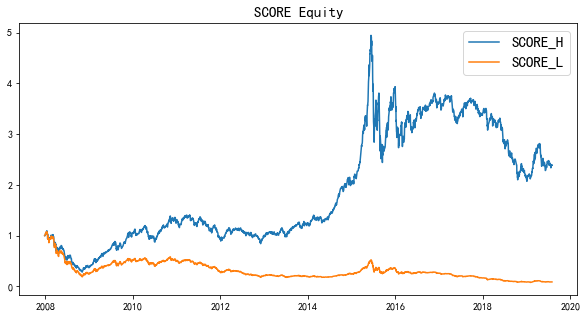

                                     LN_MV
mean_return                      -0.245003
vol_return                        0.105019
IR                                -2.33294
sharpe_ratio                       -2.6186
max_drawdown                       0.96439
mean_return_max_drawdown_ratio    -0.25405
max_drawdown_start              2007-12-28
max_drawdown_end                2017-01-10
max_drawdown_last_Y                9.03765


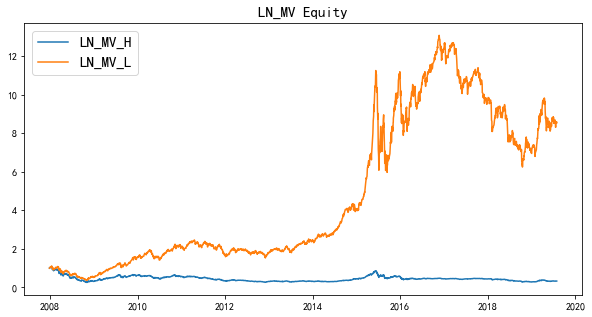

                                  ILLIQ_20
mean_return                       0.292749
vol_return                       0.0931234
IR                                 3.14367
sharpe_ratio                       2.82151
max_drawdown                     0.0984797
mean_return_max_drawdown_ratio     2.97269
max_drawdown_start              2010-09-28
max_drawdown_end                2011-04-06
max_drawdown_last_Y               0.520192


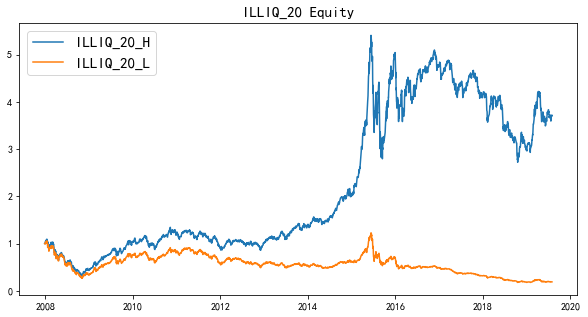

                                        BP
mean_return                      0.0700333
vol_return                       0.0811544
IR                                0.862963
sharpe_ratio                      0.493298
max_drawdown                      0.344792
mean_return_max_drawdown_ratio    0.203118
max_drawdown_start              2010-01-13
max_drawdown_end                2014-03-10
max_drawdown_last_Y                4.15332


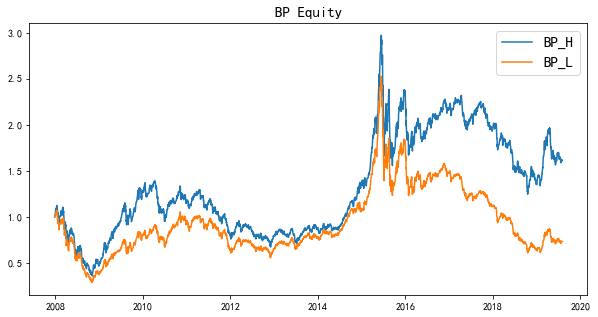

                                    VOL_60
mean_return                      0.0245274
vol_return                        0.111893
IR                                0.219204
sharpe_ratio                    -0.0489091
max_drawdown                      0.446548
mean_return_max_drawdown_ratio   0.0549268
max_drawdown_start              2014-02-12
max_drawdown_end                2017-06-01
max_drawdown_last_Y                3.29911


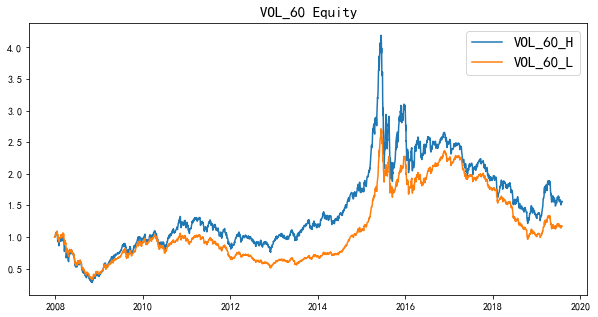

                                   ROE_YOY
mean_return                       0.156702
vol_return                       0.0602339
IR                                 2.60156
sharpe_ratio                        2.1035
max_drawdown                     0.0889537
mean_return_max_drawdown_ratio     1.76161
max_drawdown_start              2008-11-04
max_drawdown_end                2009-08-04
max_drawdown_last_Y               0.747433


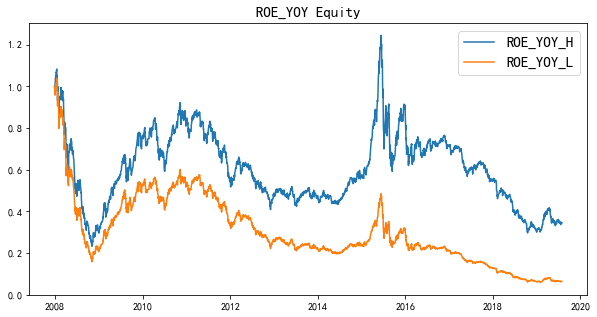

                                   EST_ROE
mean_return                     -0.0535224
vol_return                       0.0609159
IR                               -0.878627
sharpe_ratio                      -1.37111
max_drawdown                      0.528231
mean_return_max_drawdown_ratio   -0.101324
max_drawdown_start              2008-05-06
max_drawdown_end                2017-02-16
max_drawdown_last_Y                8.78303


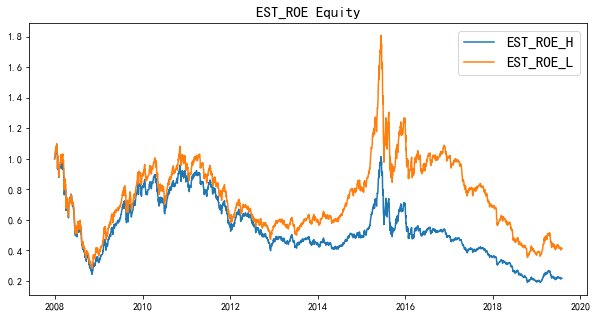

In [379]:
for key in TopTailEquityDict.keys():
    TopTailEquity=TopTailEquityDict[key]
    Result=Indicator(TopTailEquity[[TopTailEquity.columns[-1]]],key)[0]
    print(Result)
    plt.figure(figsize=(10,5))
    for col in TopTailEquity.columns[:-1]:
        plt.plot(TopTailEquity[col],label=col)
    plt.legend(loc=0,fontsize=15)
    plt.title('%s Equity'%(key),fontsize=15)
    plt.show()

# 分层抽样方法 - 指数增强策略
## 策略概述
市值和行业是很重要的风险因子，分层抽样策略的核心是使投资组合在这两个风险维度上与基准指数保持一致，然后在市值、行业属性比较相似的若干只股票里优选一只预期收益最高的进行投资，以获取超额收益。
**实际上在行业上与市值上的暴露与基准指数有一定差别。**  
**step1**:将基准指数成份股按行业划分成$S$个子集，在每个子集中用市值因子将股票划分为数目相等的三组；  
**step2**:计算每个小组内所有股票在基准指数中的总权重；  
**step3**:在每个小组中选择预期收益（打分法）最高的一只股票，令它在投资组合中的权重等于它所处小组的权重。这样就能选出包含$3S$只股票的分层抽样组合。

In [7]:
IndexHS300Weight = pd.read_csv('D:/DWDB/%s.csv'%('AIndexHS300FreeWeight'))
IndexHS300Weight['TRADE_DAYS'] = IndexHS300Weight['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
IndexEODPrices = pd.read_csv('D:/DWDB/%s.csv'%('AIndexEODPrices'))
IndexEODPrices['TRADE_DAYS'] = IndexEODPrices['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))

In [8]:
benchmarkI = '000905.SH'

In [9]:
IndexPrices=IndexEODPrices[IndexEODPrices['S_INFO_WINDCODE']==benchmarkI][['TRADE_DAYS','S_INFO_WINDCODE','S_DQ_CLOSE']].copy()
IndexPrices['基准指数']=IndexPrices['S_DQ_CLOSE']

In [10]:
IndexHS300Weight_tmp0 = IndexHS300Weight[IndexHS300Weight['S_INFO_WINDCODE']==benchmarkI].copy()
IndexHS300Weight_tmp1 = IndexHS300Weight_tmp0[['TRADE_DAYS','S_CON_WINDCODE','I_WEIGHT']].copy().rename(columns={'S_CON_WINDCODE':'S_INFO_WINDCODE'})

In [11]:
FactorBweight = AllFactorsDf_PreTAfrOrScore.merge(IndexHS300Weight_tmp1,on=['TRADE_DAYS','S_INFO_WINDCODE'],how='left')
FactorBweight['I_WEIGHT']=FactorBweight['I_WEIGHT'].fillna(0)/100

In [475]:
def CutLayer(df,SubBin):
    df_=df.copy()
    df_['GofMV']=pd.qcut(df_['LN_MV'],SubBin,labels=False)
    # 取出组内最高分
    df_0=df_.loc[df_.groupby('GofMV')['SCORE'].idxmax(),:]
    # 求出组内总权重
    df_1=df_.groupby('GofMV')['I_WEIGHT'].sum().to_frame('WEIGHT_New_I')
    df_2=df_0.merge(df_1,on=['GofMV'])
    return df_2

In [467]:
def SubjectTo1(df,col):
    df=df.copy()
    df[col]=df[col]/df[col].sum()
    return df

In [476]:
FactorBweightDict={}
for SubBin in [5,10,15,20]:
    FactorBweight_V=FactorBweight.groupby(['TRADE_DAYS','IND_CITICS']).apply(CutLayer,SubBin=SubBin)
    FactorBweight_VV=FactorBweight_V.reset_index(drop=True)
    FactorBweight_VVV = FactorBweight_VV.groupby(['TRADE_DAYS']).apply(SubjectTo1,col='WEIGHT_New_I').reset_index(drop=True)
    FactorBweightForS = FactorBweight_VVV[['TRADE_DAYS','S_INFO_WINDCODE','WEIGHT_New_I']].copy().rename(columns={'WEIGHT_New_I':'Weight_LayerCut'})
    FactorBweightDict[SubBin]=FactorBweightForS

## 策略回测

In [477]:
### 基本参数设定
start = '2007-12-01'
end = '2019-07-31'

factor_used='LayerCut'

### 回测
AllBackTestEquityDict={}
for SubBin in FactorBweightDict.keys():
    FactorBweightForS=FactorBweightDict[SubBin]
    
    ## 每期股票权重数据
    FactorForBackTest_Weight = FactorBweightForS.copy()
    strategy_name = '%s'%(factor_used)
    TopTailEquity = pd.DataFrame()
    AllEquityData = BackTest(TradeDateDf_M_Used,strategy_name,start,end,PricesDfForBackTest,FactorForBackTest_Weight)
    AllBackTestEquityDict[SubBin]=AllEquityData

分层抽样法很难取得较大偏离指数的收益，行业上的暴露与基准几乎一致，使用带有市值因子的复合因子实际上是基于减弱版市值因子的指数增强

                                  LayerCut
mean_return                      0.0383895
vol_return                        0.079346
IR                                0.483824
sharpe_ratio                      0.105733
max_drawdown                      0.138337
mean_return_max_drawdown_ratio    0.277507
max_drawdown_start              2012-07-31
max_drawdown_end                2015-04-01
max_drawdown_last_Y                2.66667


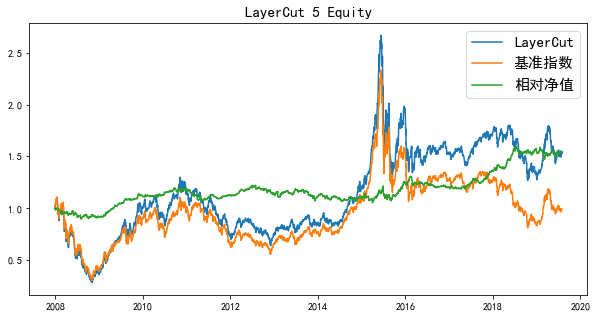

                                  LayerCut
mean_return                      0.0478468
vol_return                        0.062506
IR                                0.765474
sharpe_ratio                      0.285521
max_drawdown                      0.104176
mean_return_max_drawdown_ratio    0.459286
max_drawdown_start              2014-01-30
max_drawdown_end                2015-09-02
max_drawdown_last_Y                1.58795


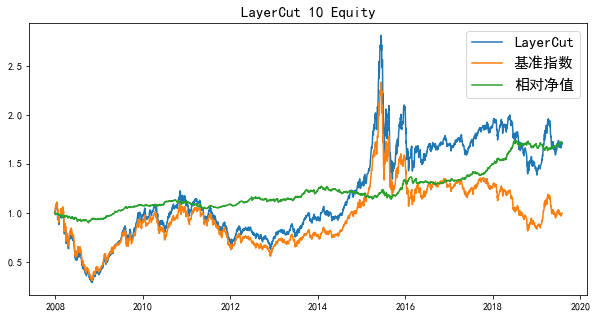

                                  LayerCut
mean_return                      0.0170528
vol_return                       0.0595955
IR                                0.286143
sharpe_ratio                     -0.217251
max_drawdown                       0.14433
mean_return_max_drawdown_ratio    0.118152
max_drawdown_start              2014-01-29
max_drawdown_end                2015-03-02
max_drawdown_last_Y                1.08693


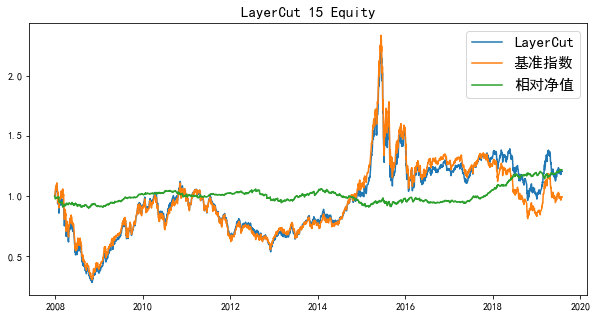

                                  LayerCut
mean_return                      0.0223004
vol_return                       0.0505705
IR                                0.440976
sharpe_ratio                     -0.152256
max_drawdown                      0.136392
mean_return_max_drawdown_ratio    0.163502
max_drawdown_start              2014-03-14
max_drawdown_end                2015-09-02
max_drawdown_last_Y                1.47023


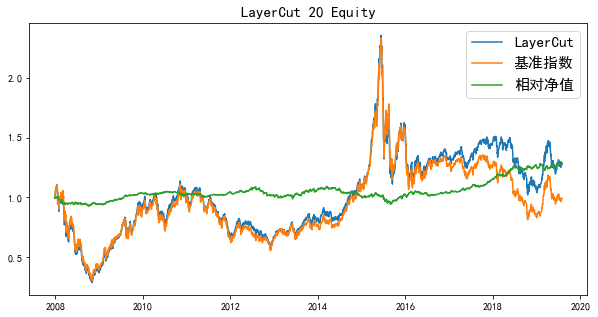

In [478]:
for SubBin in AllBackTestEquityDict.keys():
    AllEquityData=AllBackTestEquityDict[SubBin].copy()
    AllEquityData_=AllEquityData.merge(IndexPrices.set_index('TRADE_DAYS'),on=['TRADE_DAYS'],how='left')
    AllEquityData_['基准指数']=AllEquityData_['基准指数']/AllEquityData_['基准指数'].tolist()[0]
    AllEquityData_['相对净值']=AllEquityData_[factor_used]/AllEquityData_['基准指数']
    Result=Indicator(AllEquityData_[['相对净值']],factor_used)[0]
    print(Result)
    plt.figure(figsize=(10,5))
    for col in [factor_used]+['基准指数','相对净值']:
        plt.plot(AllEquityData_[col],label=col)
    plt.legend(loc=0,fontsize=15)
    plt.title('%s %d Equity'%(key,SubBin),fontsize=15)
    plt.show()

# 组合优化方法

## 指数权重数据

In [6]:
IndexHS300Weight = pd.read_csv('D:/DWDB/%s.csv'%('AIndexHS300FreeWeight'))
IndexHS300Weight['TRADE_DAYS'] = IndexHS300Weight['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
IndexEODPrices = pd.read_csv('D:/DWDB/%s.csv'%('AIndexEODPrices'))
IndexEODPrices['TRADE_DAYS'] = IndexEODPrices['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))

In [7]:
benchmarkI = '000905.SH'

In [8]:
IndexPrices=IndexEODPrices[IndexEODPrices['S_INFO_WINDCODE']==benchmarkI][['TRADE_DAYS','S_INFO_WINDCODE','S_DQ_CLOSE']].copy()
IndexPrices['基准指数']=IndexPrices['S_DQ_CLOSE']

In [9]:
IndexHS300Weight_tmp0 = IndexHS300Weight[IndexHS300Weight['S_INFO_WINDCODE']==benchmarkI].copy()
IndexHS300Weight_tmp1 = IndexHS300Weight_tmp0[['TRADE_DAYS','S_CON_WINDCODE','I_WEIGHT']].copy().rename(columns={'S_CON_WINDCODE':'S_INFO_WINDCODE'})

In [10]:
FactorBweight = AllFactorsDf_PreTAfrOrScore.merge(IndexHS300Weight_tmp1,on=['TRADE_DAYS','S_INFO_WINDCODE'],how='left')
FactorBweight['I_WEIGHT']=FactorBweight['I_WEIGHT'].fillna(0)/100

In [11]:
FactorDF_tmp = FactorBweight[[col for col in FactorBweight.columns if col not in ['IND_CITICS','I_WEIGHT']]].set_index(['TRADE_DAYS','S_INFO_WINDCODE']).copy()
FactorDF_tmp0 = FactorBweight[['TRADE_DAYS','S_INFO_WINDCODE','I_WEIGHT']].set_index(['TRADE_DAYS','S_INFO_WINDCODE']).copy()
FactorDF_tmp1=FactorDF_tmp0['I_WEIGHT']
FactorDF_Iex = FactorDF_tmp.mul(FactorDF_tmp1,axis=0).reset_index()

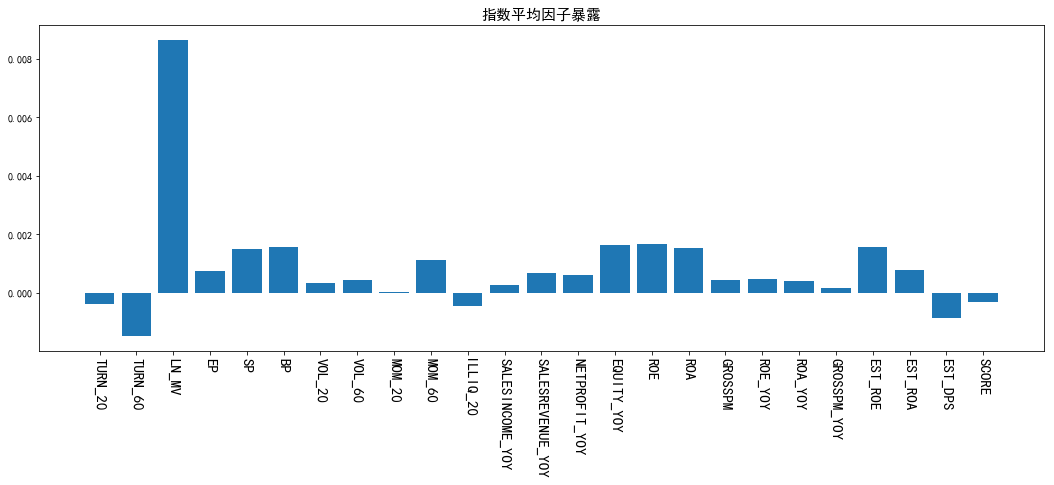

In [12]:
BenchF = FactorDF_Iex.groupby('TRADE_DAYS').sum().mean()
plt.figure(figsize=(18,6))
plt.bar(BenchF.index,BenchF.values)
plt.xticks(rotation=-90,fontsize=15)
plt.title('指数平均因子暴露',fontsize=15)
plt.show()

## 优化得到每期权重

In [13]:
start = '2007-12-01'
end = '2019-07-31'
FactorBweight_=FactorBweight[(FactorBweight['TRADE_DAYS']>=start) & (FactorBweight['TRADE_DAYS']<=end) & (FactorBweight['I_WEIGHT']!=0)].copy()

In [14]:
def combination_optimization(data_):
    ##part1：数据准备
    #1、得到目标函数的系数矩阵
    c=np.array(data_['SCORE'])   

    #2、得到约束条件数据：控制组合相对于基准指数的 因子+行业 暴露
    index_weight=np.array(data_['I_WEIGHT'])  # Nx1 生成指数成分股权重矩阵
    factors_names=[i for i in data_.columns if i not in ['TRADE_DAYS', 'S_INFO_WINDCODE', 'SCORE', 'I_WEIGHT']]  #提取因子名称
    factor_industry_df = pd.get_dummies(data_[factors_names],columns=['IND_CITICS'])
    FImat = np.array(factor_industry_df.T) # (K+S)xN
    
    ##part2：进行优化
    fun= lambda w: -w.T.dot(c)  #构建目标函数
    cons=( 
            {'type': 'ineq', 'fun':lambda w: 1.2*FImat.dot(index_weight)-FImat.dot(w)},  #因子暴露差距，ineq为大于0
            {'type': 'ineq', 'fun':lambda w: FImat.dot(w)-0.8*FImat.dot(index_weight)},  #因子暴露差距，ineq为大于0
            {'type': 'ineq', 'fun':lambda w: (w-0.8*index_weight)}, #构建约束条件3个股相对于基准指数成分股的偏离，最多不超过20%
            {'type': 'ineq', 'fun':lambda w: (1.2*index_weight-w)}, #构建约束条件3个股相对于基准指数成分股的偏离，最多不超过20%
            {'type': 'eq'  , 'fun':lambda w: np.sum(w)-1},   #构建约束条件6组合权重之和为1
          )
    
    limit=tuple((0,0.015) for x in range(len(data_))) #建立约束条件，个股权重上限，及权重的取值范围，元组
    w0=index_weight  #确定初始权重，为等权重
    res = sco.minimize(fun,w0, method='SLSQP', bounds=limit,constraints=cons)  #利用递归最小二乘求解最优权重
    data_['Weight_Optimal']=res['x']
    
    return data_

In [15]:
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst,axis=0)
FactorBweight_V=applyParallel(FactorBweight_.groupby('TRADE_DAYS'),combination_optimization)

In [16]:
FactorBweight_V.to_csv('D:/MultiFactorData/%s.csv'%('FactorBweight_V'),index=False)

In [55]:
FactorBweight_V = pd.read_csv('D:/MultiFactorData/%s.csv'%('FactorBweight_V'),parse_dates=['TRADE_DAYS'])

## 优化后组合的平均因子暴露

In [17]:
FactorBweight_V_tmp = FactorBweight_V[[col for col in FactorBweight_V.columns if col not in ['IND_CITICS','I_WEIGHT','Weight_Optimal']]].set_index(['TRADE_DAYS','S_INFO_WINDCODE']).copy()
FactorBweight_V_tmp0 = FactorBweight_V[['TRADE_DAYS','S_INFO_WINDCODE','Weight_Optimal']].set_index(['TRADE_DAYS','S_INFO_WINDCODE']).copy()
FactorBweight_V_tmp1=FactorBweight_V_tmp0['Weight_Optimal']
FactorBweight_V_Iex = FactorBweight_V_tmp.mul(FactorBweight_V_tmp1,axis=0).reset_index()

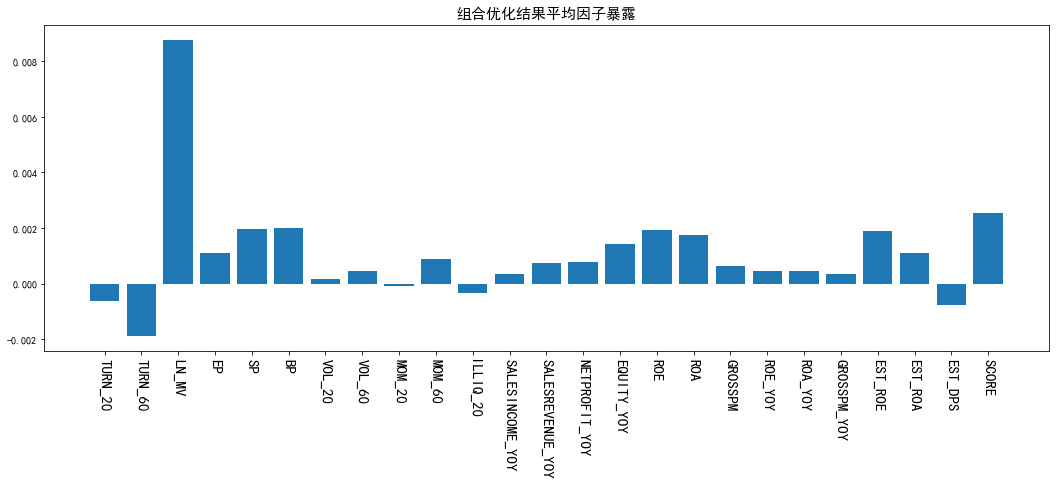

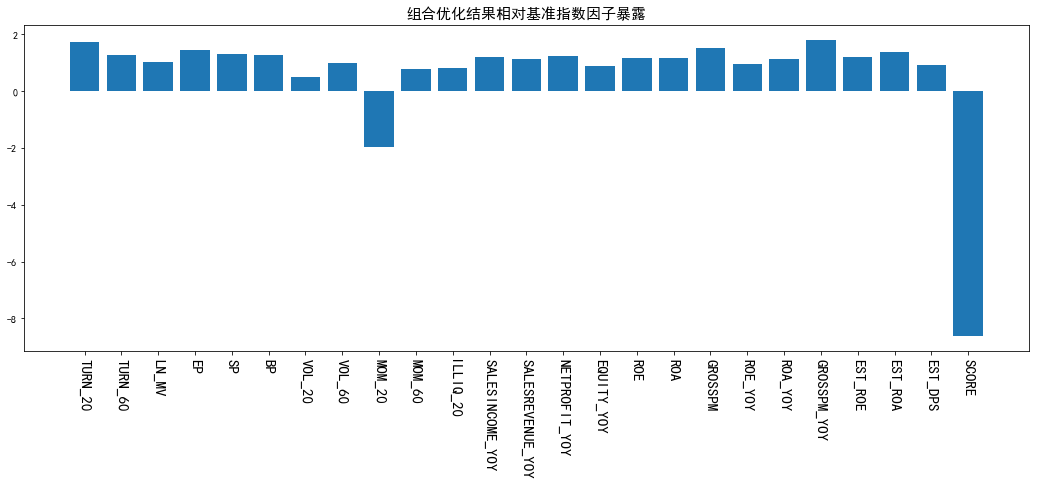

In [18]:
OptimalF = FactorBweight_V_Iex.groupby('TRADE_DAYS').sum().mean()
plt.figure(figsize=(18,6))
plt.bar(OptimalF.index,OptimalF.values)
plt.xticks(rotation=-90,fontsize=15)
plt.title('组合优化结果平均因子暴露',fontsize=15)
plt.show()

plt.figure(figsize=(18,6))
plt.bar(OptimalF.index,OptimalF.values/BenchF.values)
plt.xticks(rotation=-90,fontsize=15)
plt.title('组合优化结果相对基准指数因子暴露',fontsize=15)
plt.show()

## 优化组合回测

In [23]:
### 基本参数设定
start = '2007-12-01'
end = '2019-07-31'

factor_used='Optimal'

### 回测
## 每期股票权重数据
FactorForBackTest_Weight = FactorBweight_V.copy()
strategy_name = '%s'%(factor_used)
TopTailEquity = pd.DataFrame()
AllEquityData = BackTest(TradeDateDf_M_Used,strategy_name,start,end,PricesDfForBackTest,FactorForBackTest_Weight)

                                   Optimal
mean_return                      0.0155206
vol_return                      0.00661093
IR                                 2.34771
sharpe_ratio                      -2.19022
max_drawdown                     0.0101535
mean_return_max_drawdown_ratio      1.5286
max_drawdown_start              2014-11-04
max_drawdown_end                2014-12-22
max_drawdown_last_Y               0.131417
年化跟踪误差 0.6576%


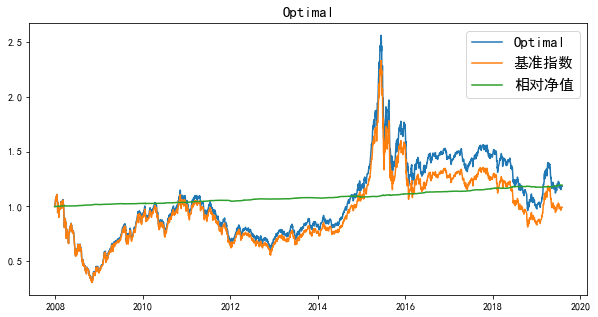

In [27]:
AllEquityData_=AllEquityData.merge(IndexPrices.set_index('TRADE_DAYS'),on=['TRADE_DAYS'],how='left')
AllEquityData_['基准指数']=AllEquityData_['基准指数']/AllEquityData_['基准指数'].tolist()[0]
AllEquityData_['相对净值']=AllEquityData_[factor_used]/AllEquityData_['基准指数']
Result=Indicator(AllEquityData_[['相对净值']],factor_used)[0]
print(Result)
print('年化跟踪误差 %.4f%%'%(100*(AllEquityData_['基准指数'].pct_change()-AllEquityData_[factor_used].pct_change()).std()*252**0.5))
plt.figure(figsize=(10,5))
for col in [factor_used]+['基准指数','相对净值']:
    plt.plot(AllEquityData_[col],label=col)
plt.legend(loc=0,fontsize=15)
plt.title('%s'%(factor_used),fontsize=15)
plt.show()